In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
## install finrl library
#!pip install wrds
#!pip install swig
#!pip install -q condacolab
#import condacolab
#condacolab.install()
#!apt-get update -y -qq && apt-get install -y -qq cmake libopenmpi-dev python3-dev zlib1g-dev libgl1-mesa-glx swig
!pip install git+https://github.com/AI4Finance-Foundation/FinRL.git

  Cloning https://github.com/AI4Finance-Foundation/FinRL.git to /tmp/pip-req-build-m07o_33g
  Running command git clone --filter=blob:none --quiet https://github.com/AI4Finance-Foundation/FinRL.git /tmp/pip-req-build-m07o_33g
  Resolved https://github.com/AI4Finance-Foundation/FinRL.git to commit fee45af12ee0af490cd8e091514173b571dcd9ed
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/AI4Finance-Foundation/ElegantRL.git to /tmp/pip-install-cl3d7v31/elegantrl_13e1e604c4dd42aca76f5b623339ca5d
  Running command git clone --filter=blob:none --quiet https://github.com/AI4Finance-Foundation/ElegantRL.git /tmp/pip-install-cl3d7v31/elegantrl_13e1e604c4dd42aca76f5b623339ca5d
  Resolved https://github.com/AI4Finance-Foundation/ElegantRL.git to commit 95a1a6bbc92e62c8d2ac470b2315d961da343889
  Preparing metadata (setup.py) ... done


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import deque

# import torch
# import torch.nn as nn
# import torch.optim as optim

from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent, DRLEnsembleAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline

from stable_baselines3 import PPO, A2C, DDPG
from stable_baselines3.common.vec_env import DummyVecEnv


Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/pandas_datareader/compat/__init__.py:11: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  PANDAS_VERSION = LooseVersion(pd.__version__)
/usr/local/lib/python3.12/dist-packages/pyfolio/pos.py:25: UserWarning: Module "zipline.assets

In [3]:
processed = pd.read_csv('/content/drive/MyDrive/RL/processed.csv', index_col=0, parse_dates=['date', 'date_available'])

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


# Experiments

In [4]:
processed.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 79464 entries, 2010-01-04 to 2023-02-28
Data columns (total 61 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   close             79464 non-null  float64       
 1   high              79464 non-null  float64       
 2   low               79464 non-null  float64       
 3   open              79464 non-null  float64       
 4   volume            79464 non-null  int64         
 5   day               79464 non-null  int64         
 6   op_inc_q          79464 non-null  float64       
 7   rev_q             79464 non-null  float64       
 8   net_inc_q         79464 non-null  float64       
 9   tot_assets        79464 non-null  float64       
 10  sh_equity         79464 non-null  float64       
 11  eps_incl_ex       79464 non-null  float64       
 12  com_eq            79464 non-null  float64       
 13  sh_outstanding    79464 non-null  float64       
 14  div_p

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# Анализ корреляции с целевой переменной (например, future_return)
correlations = []
target = processed['close'].pct_change().shift(-1)  # завтрашняя доходность

for col in processed.select_dtypes(include=[np.number]).columns:
    if col != 'close':
        corr = processed[col].corr(target)
        correlations.append((col, abs(corr)))

correlations.sort(key=lambda x: x[1], reverse=True)
print("Топ-40 признаков по корреляции с будущей доходностью:")
for col, corr in correlations:
    print(f"{col}: {corr:.4f}")

Топ-40 признаков по корреляции с будущей доходностью:
forecast_1: 0.0231
forecast_3: 0.0229
open: 0.0228
forecast_4: 0.0228
low: 0.0227
forecast_5: 0.0227
forecast_2: 0.0227
high: 0.0226
rsi_30: 0.0140
enterprise_value: 0.0140
PE_ratio: 0.0140
macd: 0.0125
market_cap: 0.0125
div_per_sh: 0.0116
DPS: 0.0116
net_inc_q: 0.0104
dividend_yield: 0.0100
PB_ratio: 0.0100
PS_ratio: 0.0093
op_inc_q: 0.0082
turbulence: 0.0063
debt_ratio: 0.0061
revenue_growth: 0.0060
day: 0.0059
dx_30: 0.0058
cci_30: 0.0053
cur_ratio: 0.0043
cash_ratio: 0.0040
long_debt: 0.0040
acc_pay_turnover: 0.0039
eps_incl_ex: 0.0037
EPS: 0.0037
short_debt: 0.0037
acc_rec_turnover: 0.0034
BPS: 0.0034
cur_liabilities: 0.0033
quick_ratio: 0.0032
NPM: 0.0030
tot_liabilities: 0.0029
tot_assets: 0.0028
inventories: 0.0023
cash_eq: 0.0023
eps_growth: 0.0023
payables: 0.0022
com_eq: 0.0020
receivables: 0.0020
sh_equity: 0.0018
OPM: 0.0015
ROE: 0.0015
debt_to_equity: 0.0010
cur_assets: 0.0010
EV_EBITDA: 0.0010
sh_outstanding: 0.0009


In [12]:
print("Топ-20 признаков по корреляции с будущей доходностью:")
for col, corr in correlations[20:]:
    print(f"{col}: {corr:.4f}")

Топ-20 признаков по корреляции с будущей доходностью:
turbulence: 0.0063
debt_ratio: 0.0061
revenue_growth: 0.0060
day: 0.0059
dx_30: 0.0058
cci_30: 0.0053
cur_ratio: 0.0043
cash_ratio: 0.0040
long_debt: 0.0040
acc_pay_turnover: 0.0039
eps_incl_ex: 0.0037
EPS: 0.0037
short_debt: 0.0037
acc_rec_turnover: 0.0034
BPS: 0.0034
cur_liabilities: 0.0033
quick_ratio: 0.0032
NPM: 0.0030
tot_liabilities: 0.0029
tot_assets: 0.0028
inventories: 0.0023
cash_eq: 0.0023
eps_growth: 0.0023
payables: 0.0022
com_eq: 0.0020
receivables: 0.0020
sh_equity: 0.0018
OPM: 0.0015
ROE: 0.0015
debt_to_equity: 0.0010
cur_assets: 0.0010
EV_EBITDA: 0.0010
sh_outstanding: 0.0009
rev_q: 0.0009
inv_turnover: 0.0007
cogs_q: 0.0006
volume: 0.0004
ROA: 0.0003


In [ ]:
# Топ признаков по корреляции + важные дополнения
TOP_CORRELATED_FEATURES = [
    # 1. Прогнозы GRU (первые 3 - самые сильные)
    'forecast_1', 'forecast_2', 'forecast_3','forecast_4', 'forecast_5',

    # 2. Ценовые данные (4 признака)
    'open', 'low', 'high', 'close',

    # 3. Объем (важен для подтверждения трендов)
    'volume',

    # 4. Технические индикаторы (4 признака)
    'rsi_30', 'macd', 'cci_30','dx_30',

    # 5. Фундаментальные (2 признака из топа)
    'PE_ratio', 'enterprise_value',

    'OPM', 'NPM', 'ROA', 'ROE', 'cur_ratio',
    'quick_ratio', 'cash_ratio',
    'inv_turnover', 'acc_rec_turnover', 'acc_pay_turnover',
    'debt_ratio','debt_to_equity', 'PB_ratio', 'dividend_yield',

    # 6. Риск-метрика
    'turbulence',

    # 7. Дивиденды (сигнал устойчивости компании)
    'div_per_sh'
]

In [15]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
TOP_CORRELATED_FEATURES = [
    # 1. Прогнозы GRU (только лучшие 3 - остальные слишком коррелированы)
    'forecast_1', 'forecast_2', 'forecast_3',

    # 2. Ценовые данные (упрощаем - high/low/open сильно коррелируют с close)
    'close', 'open',  # open важен для gaps

    # 3. Технические индикаторы (выбираем диверсифицированные)
    'rsi_30',      # осциллятор (0.0140)
    'macd',        # тренд (0.0125)
    'dx_30',       # сила тренда (0.0058)
    # 'cci_30' исключаем - коррелирует с rsi_30 (0.0053)

    # 4. Фундаментальные (выбираем НЕкоррелирующие между собой)
    'PE_ratio',          # оценка (0.0140)
    'enterprise_value',  # размер компании (0.0140)
    'div_per_sh',        # дивиденды (0.0116)
    'debt_ratio',        # долговая нагрузка (0.0061)
    'revenue_growth',    # рост (0.0060)

    # 5. Показатели эффективности (по 1 из каждой категории)
    'NPM',               # маржа чистой прибыли (0.0030)
    # исключаем OPM, ROA, ROE - низкая корреляция

    # 6. Ликвидность (выбираем 1-2)
    'cur_ratio',         # текущая ликвидность (0.0043)
    # исключаем quick_ratio, cash_ratio - похожи

    # 7. Деловая активность (выбираем 1)
    'acc_pay_turnover',  # оборачиваемость кредиторки (0.0039)
    # исключаем inv_turnover, acc_rec_turnover - низкая корреляция

    # 8. Риск
    'turbulence',        # турбулентность (0.0063)

    # 9. Время (слабая, но может быть полезна для сезонности)
    'day',               # день месяца (0.0059)
]

print(f"Итого признаков для VIF-анализа: {len(TOP_CORRELATED_FEATURES)}")


print(f"Отобранных признаков: {len(TOP_CORRELATED_FEATURES)}")
def check_vif(features_df):
    """Проверка мультиколлинеарности через VIF"""
    vif_data = pd.DataFrame()
    vif_data["feature"] = features_df.columns

    # Вычисляем VIF
    vif_data["VIF"] = [variance_inflation_factor(features_df.values, i)
                       for i in range(len(features_df.columns))]

    return vif_data.sort_values("VIF", ascending=False)

# Создаем DataFrame с выбранными признаками
features_df = processed[TOP_CORRELATED_FEATURES].dropna()

Итого признаков для VIF-анализа: 18
Отобранных признаков: 18


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [16]:
# Проверяем VIF
vif_results = check_vif(features_df)
print("Мультиколлинеарность (VIF > 10 - проблема):")
print(vif_results)

Мультиколлинеарность (VIF > 10 - проблема):
             feature           VIF
4               open  11712.279644
2         forecast_3   6328.476170
3              close   5468.589397
0         forecast_1   5271.403371
1         forecast_2   2202.557631
5             rsi_30     25.049043
11        debt_ratio     14.504754
14         cur_ratio      8.083324
10        div_per_sh      6.166212
13               NPM      4.197852
15  acc_pay_turnover      3.582487
7              dx_30      3.103086
8           PE_ratio      3.087091
17               day      3.041703
9   enterprise_value      2.642484
16        turbulence      1.665835
6               macd      1.342587
12    revenue_growth      1.192416


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [18]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def pca_feature_reduction(data, features, n_components=0.95):
    """
    Сокращение признаков с помощью PCA
    """
    df = data[features].copy().fillna(method='ffill')

    # Стандартизация
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df)

    # PCA
    pca = PCA(n_components=n_components)
    pca_data = pca.fit_transform(scaled_data)

    print(f"PCA результаты:")
    print(f"Оригинальные признаки: {len(features)}")
    print(f"PCA компоненты: {pca.n_components_}")
    print(f"Объясненная дисперсия: {pca.explained_variance_ratio_.sum():.3f}")

    # Важность признаков в каждой компоненте
    loadings = pd.DataFrame(
        pca.components_.T,
        columns=[f'PC{i+1}' for i in range(pca.n_components_)],
        index=features
    )

    print("\nТоп-5 признаков по важности в первой компоненте:")
    print(loadings['PC1'].abs().sort_values(ascending=False))

    return pca_data, loadings

# Если VIF показывает высокую мультиколлинеарность
pca_features, loadings = pca_feature_reduction(
    processed,
    TOP_CORRELATED_FEATURES,
    n_components=0.95  # объяснить 95% дисперсии
)

/tmp/ipython-input-3751265045.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = data[features].copy().fillna(method='ffill')


PCA результаты:
Оригинальные признаки: 18
PCA компоненты: 12
Объясненная дисперсия: 0.956

Топ-5 признаков по важности в первой компоненте:
forecast_2          0.402279
open                0.402268
close               0.402254
forecast_3          0.401960
forecast_1          0.401665
div_per_sh          0.252283
debt_ratio          0.206754
enterprise_value    0.193279
PE_ratio            0.153713
cur_ratio           0.100090
macd                0.081861
acc_pay_turnover    0.071525
revenue_growth      0.030504
rsi_30              0.029088
turbulence          0.023284
NPM                 0.007879
dx_30               0.006563
day                 0.000496
Name: PC1, dtype: float64


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [19]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

def feature_importance_analysis(data, features, target='close'):
    """Анализ важности признаков"""
    # Подготовка данных
    X = data[features].copy().fillna(method='ffill')
    y = data[target].pct_change().shift(-1)  # будущая доходность

    # Выравнивание
    aligned_idx = X.index.intersection(y.dropna().index)
    X = X.loc[aligned_idx]
    y = y.loc[aligned_idx]

    # Разделение
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, shuffle=False
    )

    # Обучение
    rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    rf.fit(X_train, y_train)

    # Важность признаков
    importance = pd.DataFrame({
        'feature': features,
        'importance': rf.feature_importances_
    }).sort_values('importance', ascending=False)

    print("Топ-15 важных признаков по RandomForest:")
    print(importance.head(15).to_string())

    return importance

# Анализ
importance_df = feature_importance_analysis(processed, TOP_CORRELATED_FEATURES)

# Выбор признаков по порогу важности
threshold = 0.01  # 1%
selected_features = importance_df[importance_df['importance'] > threshold]['feature'].tolist()
print(f"\nПризнаки с важностью >{threshold}: {len(selected_features)}")
print(selected_features)

/tmp/ipython-input-37630912.py:7: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = data[features].copy().fillna(method='ffill')
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and s

Топ-15 важных признаков по RandomForest:
             feature  importance
16        turbulence    0.193615
6               macd    0.117145
5             rsi_30    0.084176
7              dx_30    0.081277
9   enterprise_value    0.070383
8           PE_ratio    0.063867
17               day    0.049222
12    revenue_growth    0.042483
13               NPM    0.036409
3              close    0.036231
11        debt_ratio    0.035190
15  acc_pay_turnover    0.033752
4               open    0.030514
14         cur_ratio    0.028838
10        div_per_sh    0.026484

Признаки с важностью >0.01: 18
['turbulence', 'macd', 'rsi_30', 'dx_30', 'enterprise_value', 'PE_ratio', 'day', 'revenue_growth', 'NPM', 'close', 'debt_ratio', 'acc_pay_turnover', 'open', 'cur_ratio', 'div_per_sh', 'forecast_1', 'forecast_3', 'forecast_2']


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Используйте только прогнозы GRU по следующим причинам:

Прогнозы GRU уже включают информацию о ценах (они обучены на них)

PCA показывает, что прогнозы имеют максимальную нагрузку в первой компоненте

Избегаем мультиколлинеарности - убираем open, close

Сохраняем информативность - прогнозы лучше чем сырые цены

Таким образом оптимальный набор

In [23]:
OPTIMIZED_FEATURES = [
    # 1. Прогнозы GRU (2 лучших)
    'forecast_1', 'forecast_3',  # forecast_2 исключаем как промежуточный

    # 2. Технические индикаторы (3 разных типа)
    'macd',      # тренд и моментум
    'rsi_30',    # осциллятор, перекупленность
    'dx_30',     # сила тренда

    # 3. Фундаментальные (2 некоррелированных)
    'PE_ratio',          # оценка компании
    'enterprise_value',  # размер компании

    # 4. Финансовое здоровье
    'debt_ratio',        # долговая нагрузка

    # 5. Операционная эффективность
    'acc_pay_turnover',  # оборачиваемость кредиторки
    'NPM',               # чистая маржа

    # 6. Рост бизнеса
    'revenue_growth',    # рост выручки

    # 7. Риск-метрика (самый важный!)
    'turbulence',

    # 8. Временной фактор
    'day'               # день месяца для сезонности
]

Финальный оптимизированный набор: 13 признаков
Признаки: ['forecast_1', 'forecast_3', 'macd', 'rsi_30', 'dx_30', 'PE_ratio', 'enterprise_value', 'debt_ratio', 'acc_pay_turnover', 'NPM', 'revenue_growth', 'turbulence', 'day']


In [ ]:
def check_final_vif(data, features):
    """Проверка VIF для финального набора"""
    df = data[features].copy().fillna(method='ffill')

    vif_data = pd.DataFrame()
    vif_data["feature"] = df.columns
    vif_data["VIF"] = [
        variance_inflation_factor(df.values, i)
        for i in range(len(df.columns))
    ]

    vif_data = vif_data.sort_values("VIF", ascending=False)

    print("Мультиколлинеарность финального набора:")
    print(vif_data.to_string())
    print(f"\nМаксимальный VIF: {vif_data['VIF'].max():.2f}")
    print(f"Средний VIF: {vif_data['VIF'].mean():.2f}")

    # Проверка порогов
    high_vif = vif_data[vif_data['VIF'] > 10]
    moderate_vif = vif_data[(vif_data['VIF'] > 5) & (vif_data['VIF'] <= 10)]

    if len(high_vif) > 0:
        print(f"\n⚠️  ВНИМАНИЕ: {len(high_vif)} признаков с VIF > 10:")
        print(high_vif[['feature', 'VIF']].to_string())
    else:
        print("✓ Нет признаков с VIF > 10")

    return vif_data

In [24]:
# Проверяем
final_vif = check_final_vif(processed, FINAL_FEATURES)

/tmp/ipython-input-68622344.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = data[features].copy().fillna(method='ffill')
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Мультиколлинеарность финального набора:
             feature          VIF
1         forecast_3  2984.209435
0         forecast_1  2979.918959
3             rsi_30    20.785003
7         debt_ratio    13.241510
9                NPM     3.403746
4              dx_30     3.097730
12               day     3.033206
5           PE_ratio     3.002571
8   acc_pay_turnover     2.907971
6   enterprise_value     2.559349
11        turbulence     1.660972
2               macd     1.291804
10    revenue_growth     1.170895

Максимальный VIF: 2984.21
Средний VIF: 463.10

⚠️  ВНИМАНИЕ: 4 признаков с VIF > 10:
      feature          VIF
1  forecast_3  2984.209435
0  forecast_1  2979.918959
3      rsi_30    20.785003
7  debt_ratio    13.241510


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [4]:
# Убираем rsi_30 и debt_ratio
# Преобразуем forecast в одну переменную
def create_forecast_features(data):
    """Создание агрегированных признаков из прогнозов"""
    df = data.copy()

    # 1. Средний прогноз
    df['forecast_mean'] = df[['forecast_1', 'forecast_3']].mean(axis=1)

    # 2. Разброс прогнозов (неопределенность)
    df['forecast_std'] = df[['forecast_1', 'forecast_3']].std(axis=1)

    # 3. Тренд прогнозов
    df['forecast_trend'] = df['forecast_3'] - df['forecast_1']

    return df

# 1. Создаем агрегированные прогнозные признаки
processed = create_forecast_features(processed)

# 2. Финальный проверенный набор
FINAL_FEATURES = [
    # Прогнозные (агрегированные)
    'forecast_mean',      # основной сигнал
    'forecast_std',       # уверенность прогноза
    'forecast_trend',     # изменение прогнозов

    # Технические
    'macd',
    'dx_30',

    # Фундаментальные
    'PE_ratio',

    # Бизнес-метрики
    'NPM',
    'acc_pay_turnover',
    'revenue_growth',

    # Риск
    'turbulence',

    # Время
    'day'
]

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [25]:
# 3. Проверяем VIF
print("Проверка финального набора...")
final_vif = check_final_vif(processed, FINAL_FEATURES)

Проверка финального набора...


/tmp/ipython-input-68622344.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = data[features].copy().fillna(method='ffill')
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Мультиколлинеарность финального набора:
             feature       VIF
0      forecast_mean  3.836353
5           PE_ratio  2.804396
6                NPM  2.751018
10               day  2.606471
4              dx_30  2.560930
7   acc_pay_turnover  2.252699
1       forecast_std  1.729395
9         turbulence  1.636837
8     revenue_growth  1.160188
3               macd  1.121797
2     forecast_trend  1.049338

Максимальный VIF: 3.84
Средний VIF: 2.14
✓ Нет признаков с VIF > 10


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [5]:
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)
TRAIN_START_DATE = '2010-01-01'
TRAIN_END_DATE = '2021-10-01'
TEST_START_DATE = '2021-10-01'
TEST_END_DATE = '2023-03-01'

In [9]:
processed = processed.reset_index()

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [10]:
# Data Split
train = data_split(processed, TRAIN_START_DATE, TRAIN_END_DATE)
trade = data_split(processed, TEST_START_DATE, TEST_END_DATE)

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


## Custom Environment with Quadratic Utility Reward

In [15]:
# Custom Environment with Quadratic Utility Reward
class CustomStockTradingEnv(StockTradingEnv):
    def __init__(self, *args, sigma_target=0.15/252**0.5, lambda_param=0.01, **kwargs):
        super().__init__(*args, **kwargs)
        # Параметры функции награды
        self.sigma_target = sigma_target  # целевая дневная волатильность (15% годовых / √252)
        self.lambda_param = lambda_param  # коэффициент неприятия риска

        # Для отслеживания истории
        self.previous_price = None
        self.previous_total_asset = None
        self.previous_position = None
        self.previous_sigma = None

        # История доходностей для расчета волатильности
        self.returns_history = []
        self.window_size = 20  # окно для расчета волатильности

    def _calculate_reward(self, action):
        # Текущие значения
        current_price = self.state[2]  # цена актива
        current_total_asset = self.state[0]  # общий капитал

        # Инициализация на первом шаге
        if self.previous_price is None:
            self.previous_price = current_price
            self.previous_total_asset = current_total_asset
            self.previous_position = self.state[1]  # количество акций
            self.previous_sigma = 0.01  # начальное значение волатильности
            return 0

        # 1. Рассчитываем доходность актива
        asset_return = (current_price - self.previous_price) / self.previous_price

        # 2. Обновляем историю доходностей и рассчитываем волатильность
        self.returns_history.append(asset_return)
        if len(self.returns_history) > self.window_size:
            self.returns_history.pop(0)

        # Текущая оценка волатильности (σ_{t-1} для следующего шага)
        current_sigma = np.std(self.returns_history) if len(self.returns_history) > 1 else 0.01

        # 3. Рассчитываем нормализованную позицию A_{t-1}
        # В статье: A ∈ [-1, 1] - нормализованная позиция
        # У нас: позиция в акциях, нормализуем к максимально возможной
        max_position = self.previous_total_asset / self.previous_price
        A_t_minus_1 = self.previous_position / max_position if max_position > 0 else 0

        # 4. Рассчитываем r_t (аддитивная доходность на одну единицу позиции)
        # В статье: r_t = p_t - p_{t-1} (для одного контракта)
        # У нас адаптируем: r_t = (p_t - p_{t-1}) / p_{t-1} (доходность)
        r_t = asset_return

        # 5. Основная часть функции награды: квадратичная полезность с волатильностным масштабированием
        scale_factor = self.sigma_target / self.previous_sigma if self.previous_sigma > 0 else 1.0

        # Квадратичная полезность: A_{t-1} * r_t - λ * (A_{t-1} * r_t)^2
        position_return = A_t_minus_1 * r_t
        utility = position_return - self.lambda_param * (position_return ** 2)

        # Масштабируем
        reward_before_cost = scale_factor * utility

        # 6. Транзакционные издержки (адаптировано под нашу среду)
        # В статье: bp * p_{t-1} * | (σ_tgt/σ_{t-1})*A_{t-1} - (σ_tgt/σ_{t-2})*A_{t-2} |
        # У нас упрощаем: стандартные издержки среды

        # Рассчитываем изменение позиции в нормализованном виде
        current_max_position = current_total_asset / current_price if current_price > 0 else 0
        A_t = self.state[1] / current_max_position if current_max_position > 0 else 0

        # Транзакционные издержки как в оригинальной статье
        if hasattr(self, 'previous_scale_factor') and hasattr(self, 'previous_A_t_minus_2'):
            # Если есть данные о двух предыдущих шагах
            cost = self.buy_cost_pct * self.previous_price * abs(
                scale_factor * A_t_minus_1 - self.previous_scale_factor * self.previous_A_t_minus_2
            )
        else:
            # Упрощенный расчет на первых шагах
            trades = action - self.previous_position
            cost = np.abs(trades) * current_price * self.buy_cost_pct

        # 7. Итоговая награда
        step_reward = reward_before_cost * self.previous_total_asset - cost

        # 8. Сохраняем значения для следующего шага
        self.previous_price = current_price
        self.previous_total_asset = current_total_asset
        self.previous_position = self.state[1]

        # Для расчета издержек на следующем шаге
        self.previous_A_t_minus_2 = A_t_minus_1
        self.previous_scale_factor = scale_factor
        self.previous_sigma = current_sigma

        return step_reward * self.reward_scaling

    def reset(self, seed=None, options=None):
        """
        Переопределяем reset с поддержкой seed для Stable-Baselines3
        """
        # Вызываем родительский reset с seed, если он поддерживается
        try:
            state = super().reset(seed=seed)
        except TypeError:
            # Если родительский класс не принимает seed
            state = super().reset()

        # Сбрасываем наши дополнительные переменные
        self.previous_price = None
        self.previous_total_asset = None
        self.previous_position = None
        self.previous_sigma = None
        self.previous_scale_factor = None
        self.previous_A_t_minus_2 = None
        self.returns_history = []

        return state



# Env kwargs
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(FINAL_FEATURES)*stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "buy_cost_pct": [0.001]*stock_dimension,
    "sell_cost_pct": [0.001]*stock_dimension,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": FINAL_FEATURES,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4,
    "print_verbosity":5
}

In [16]:
state_space

313

# RL Algorithms Overview for FinRL

| Algorithm | Description | When to Use | Key Logic Difference |
|-----------|-------------|-------------|----------------------|
| **A2C** | Synchronous Actor-Critic. One agent collects data and updates. | Simple environments, low compute, stability over speed. | **Synchronous**, single thread → lower variance, slower. |
| **DDPG** | Deep Deterministic Policy Gradient. Off-policy Actor-Critic for **continuous actions**. | Continuous action spaces (e.g., trade size), unstable dynamics. | **Off-policy + deterministic policy**; uses Q-learning for critic. |
| **PPO** | Proximal Policy Optimization. On-policy with **clipped probability ratio**. | **Default choice** in FinRL — stable, sample-efficient. | **On-policy + clipping** → prevents large policy shifts. |
| **TD3** | Twin Delayed DDPG. Fixes overestimation with **dual critics**, delayed updates, target noise. | Continuous actions + **Q-value overestimation** issues. | **Twin critics + delay + noise** → more robust Q-learning. |
| **SAC** | Soft Actor-Critic. Off-policy, maximizes **entropy** for exploration. | Complex environments, sparse rewards, need adaptive exploration. | **Entropy regularization** → balances exploration automatically. |


In [17]:
import torch
# Общие параметры
timesteps_dict = {'a2c': 50000, 'ppo': 50000, 'ddpg': 50000, 'td3': 50000, 'sac': 50000}

base_policy_kwargs = dict(
    net_arch=dict(
        pi=[400, 300],  # сеть актора (policy)
        vf=[400, 300]   # сеть критика (value function)
    ),
    activation_fn=torch.nn.Tanh
)

ddpg_policy_kwargs = dict(
    net_arch=dict(
        pi=[400, 300],  # акторная сеть
        qf=[400, 300]   # критическая сеть (qf = Q-function)
    ),
    activation_fn=torch.nn.Tanh
)

# A2C
A2C_model_kwargs = {
    "n_steps": 10,
    "ent_coef": 0.01,
    "learning_rate": 0.0005,
    "gamma": 0.95
}

# PPO
PPO_model_kwargs = {
    "n_steps": 4096,
    "ent_coef": 0.01,
    "learning_rate": 0.0001,
    "batch_size": 128,
    "gamma": 0.95,
    "gae_lambda": 0.95,
    "clip_range": 0.2
}

# DDPG
DDPG_model_kwargs = {
    "batch_size": 256,
    "buffer_size": 500000,
    "learning_rate": 0.0005,
    "tau": 0.001,
    "gamma": 0.95
}


In [18]:
# Build env instances
e_train_gym = CustomStockTradingEnv(df=train, num_stock_shares=[0]*len(train['tic'].unique()), **env_kwargs)
env_train, _ = e_train_gym.get_sb_env()

e_trade_gym = CustomStockTradingEnv(df=trade, num_stock_shares=[0]*len(train['tic'].unique()), turbulence_threshold=70, risk_indicator_col='turbulence', **env_kwargs)
env_trade, _ = e_trade_gym.get_sb_env()


In [19]:
import os
from pathlib import Path

# Указываем корневую директорию в Google Drive
BASE_DIR = "/content/drive/MyDrive/RL"

# Создаем поддиректории
DATA_SAVE_DIR = f"{BASE_DIR}/datasets"
TRAINED_MODEL_DIR = f"{BASE_DIR}/trained_models"
TENSORBOARD_LOG_DIR = f"{BASE_DIR}/tensorboard_logs"
RESULTS_DIR = f"{BASE_DIR}/results"

# Создаем все необходимые директории
from finrl.main import check_and_make_directories
check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])

# Проверяем, что директории созданы
print("Директории созданы:")
print(f"  Данные: {DATA_SAVE_DIR}")
print(f"  Модели: {TRAINED_MODEL_DIR}")
print(f"  Логи TensorBoard: {TENSORBOARD_LOG_DIR}")
print(f"  Результаты: {RESULTS_DIR}")

# Сохраняем обработанные данные
print("\nСохранение обработанных данных...")
processed.to_parquet(f"{DATA_SAVE_DIR}/processed_data.parquet")
train.to_parquet(f"{DATA_SAVE_DIR}/train_data.parquet")
trade.to_parquet(f"{DATA_SAVE_DIR}/trade_data.parquet")
print("Данные сохранены")

# Сохраняем конфигурацию признаков
import json
config = {
    "FINAL_FEATURES": FINAL_FEATURES,
    "stock_dimension": stock_dimension,
    "state_space": state_space,
    "env_kwargs": env_kwargs
}

with open(f"{DATA_SAVE_DIR}/config.json", "w") as f:
    json.dump(config, f, indent=2)

# Настройка логгеров и обучение моделей
from stable_baselines3.common.logger import configure

# 1. DDPG
print("\n" + "="*50)
print("ОБУЧЕНИЕ DDPG АГЕНТА")
print("="*50)

agent_ddpg = DRLAgent(env=env_train)
model_ddpg = agent_ddpg.get_model("ddpg", model_kwargs=DDPG_model_kwargs,
                                  policy_kwargs=ddpg_policy_kwargs, verbose=1)

# Настраиваем логгер для DDPG
ddpg_log_dir = f"{RESULTS_DIR}/ddpg"
os.makedirs(ddpg_log_dir, exist_ok=True)
new_logger_ddpg = configure(ddpg_log_dir, ["stdout", "csv", "tensorboard"])
model_ddpg.set_logger(new_logger_ddpg)

# Обучаем DDPG
trained_ddpg = agent_ddpg.train_model(
    model_ddpg,
    tb_log_name='ddpg',
    total_timesteps=timesteps_dict['ddpg']
)

# Сохраняем модель DDPG
ddpg_model_path = f"{TRAINED_MODEL_DIR}/ddpg_model"
trained_ddpg.save(ddpg_model_path)
print(f"DDPG модель сохранена в: {ddpg_model_path}")

# 2. PPO
print("\n" + "="*50)
print("ОБУЧЕНИЕ PPO АГЕНТА")
print("="*50)

agent_ppo = DRLAgent(env=env_train)
model_ppo = agent_ppo.get_model("ppo", model_kwargs=PPO_model_kwargs,
                                policy_kwargs=base_policy_kwargs, verbose=1)

# Настраиваем логгер для PPO
ppo_log_dir = f"{RESULTS_DIR}/ppo"
os.makedirs(ppo_log_dir, exist_ok=True)
new_logger_ppo = configure(ppo_log_dir, ["stdout", "csv", "tensorboard"])
model_ppo.set_logger(new_logger_ppo)

# Обучаем PPO
trained_ppo = agent_ppo.train_model(
    model_ppo,
    tb_log_name='ppo',
    total_timesteps=timesteps_dict['ppo']
)

# Сохраняем модель PPO
ppo_model_path = f"{TRAINED_MODEL_DIR}/ppo_model"
trained_ppo.save(ppo_model_path)
print(f"PPO модель сохранена в: {ppo_model_path}")

# 3. A2C
print("\n" + "="*50)
print("ОБУЧЕНИЕ A2C АГЕНТА")
print("="*50)

agent_a2c = DRLAgent(env=env_train)
model_a2c = agent_a2c.get_model("a2c", model_kwargs=A2C_model_kwargs,
                                policy_kwargs=base_policy_kwargs, verbose=1)

# Настраиваем логгер для A2C
a2c_log_dir = f"{RESULTS_DIR}/a2c"
os.makedirs(a2c_log_dir, exist_ok=True)
new_logger_a2c = configure(a2c_log_dir, ["stdout", "csv", "tensorboard"])
model_a2c.set_logger(new_logger_a2c)

# Обучаем A2C
trained_a2c = agent_a2c.train_model(
    model_a2c,
    tb_log_name='a2c',
    total_timesteps=timesteps_dict['a2c']
)

# Сохраняем модель A2C
a2c_model_path = f"{TRAINED_MODEL_DIR}/a2c_model"
trained_a2c.save(a2c_model_path)
print(f"A2C модель сохранена в: {a2c_model_path}")

# Сохраняем метаданные обучения
import pandas as pd
from datetime import datetime

training_metadata = {
    "model": ["ddpg", "ppo", "a2c"],
    "timesteps": [
        timesteps_dict.get('ddpg', 0),
        timesteps_dict.get('ppo', 0),
        timesteps_dict.get('a2c', 0)
    ],
    "model_path": [
        ddpg_model_path,
        ppo_model_path,
        a2c_model_path
    ],
    "log_dir": [
        ddpg_log_dir,
        ppo_log_dir,
        a2c_log_dir
    ],
    "training_date": [datetime.now().strftime("%Y-%m-%d %H:%M:%S")] * 3
}

metadata_df = pd.DataFrame(training_metadata)
metadata_df.to_csv(f"{RESULTS_DIR}/training_metadata.csv", index=False)

print("\n" + "="*50)
print("ВСЕ МОДЕЛИ ОБУЧЕНЫ И СОХРАНЕНЫ")
print("="*50)
print(f"\nСохранено в Google Drive: {BASE_DIR}")
print(f"\nСтруктура сохраненных данных:")
for root, dirs, files in os.walk(BASE_DIR):
    level = root.replace(BASE_DIR, '').count(os.sep)
    indent = ' ' * 2 * level
    print(f'{indent}{os.path.basename(root)}/')
    subindent = ' ' * 2 * (level + 1)
    for file in files[:5]:  # Показываем первые 5 файлов
        print(f'{subindent}{file}')
    if len(files) > 5:
        print(f'{subindent}... и еще {len(files)-5} файлов')

# Код для загрузки TensorBoard (опционально)
print("\n" + "="*50)
print("ЗАГРУЗКА TENSORBOARD (для визуализации):")
print("="*50)
print(f"""
Для визуализации обучения в TensorBoard выполните в ячейке:

%load_ext tensorboard
%tensorboard --logdir "{TENSORBOARD_LOG_DIR}"

Или загрузите логи и просмотрите локально.
""")

# Функции для загрузки моделей позже
def load_trained_models():
    """Загружает сохраненные модели"""
    from stable_baselines3 import DDPG, PPO, A2C

    models = {}

    # Загружаем DDPG
    if os.path.exists(ddpg_model_path + ".zip"):
        models['ddpg'] = DDPG.load(ddpg_model_path)
        print(f"DDPG загружен из {ddpg_model_path}")

    # Загружаем PPO
    if os.path.exists(ppo_model_path + ".zip"):
        models['ppo'] = PPO.load(ppo_model_path)
        print(f"PPO загружен из {ppo_model_path}")

    # Загружаем A2C
    if os.path.exists(a2c_model_path + ".zip"):
        models['a2c'] = A2C.load(a2c_model_path)
        print(f"A2C загружен из {a2c_model_path}")

    return models

print("\n" + "="*50)
print("ДЛЯ ЗАГРУЗКИ МОДЕЛЕЙ ПОЗЖЕ:")
print("="*50)
print("""
Используйте функцию load_trained_models() для загрузки сохраненных моделей:

models = load_trained_models()
ddpg_model = models['ddpg']
ppo_model = models['ppo']
a2c_model = models['a2c']
""")

# Сохраняем Python код для воспроизведения
code_to_save = f'''
# Код для воспроизведения эксперимента
import os
import pandas as pd
import numpy as np
from finrl import config
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from stable_baselines3 import DDPG, PPO, A2C

BASE_DIR = "{BASE_DIR}"
DATA_SAVE_DIR = f"{{BASE_DIR}}/datasets"
TRAINED_MODEL_DIR = f"{{BASE_DIR}}/trained_models"
RESULTS_DIR = f"{{BASE_DIR}}/results"

# Загрузка данных
processed = pd.read_parquet(f"{{DATA_SAVE_DIR}}/processed_data.parquet")
train = pd.read_parquet(f"{{DATA_SAVE_DIR}}/train_data.parquet")
trade = pd.read_parquet(f"{{DATA_SAVE_DIR}}/trade_data.parquet")

# Загрузка конфигурации
import json
with open(f"{{DATA_SAVE_DIR}}/config.json", "r") as f:
    config = json.load(f)

FINAL_FEATURES = config["FINAL_FEATURES"]
stock_dimension = config["stock_dimension"]
state_space = config["state_space"]
env_kwargs = config["env_kwargs"]

print("Данные и конфигурация загружены успешно!")
'''

with open(f"{BASE_DIR}/reproduce_experiment.py", "w") as f:
    f.write(code_to_save)

print(f"\nСохранен код для воспроизведения: {BASE_DIR}/reproduce_experiment.py")

Директории созданы:
  Данные: /content/drive/MyDrive/RL/datasets
  Модели: /content/drive/MyDrive/RL/trained_models
  Логи TensorBoard: /content/drive/MyDrive/RL/tensorboard_logs
  Результаты: /content/drive/MyDrive/RL/results

Сохранение обработанных данных...
Данные сохранены

ОБУЧЕНИЕ DDPG АГЕНТА
{'batch_size': 256, 'buffer_size': 500000, 'learning_rate': 0.0005, 'tau': 0.001, 'gamma': 0.95}
Using cuda device
Logging to /content/drive/MyDrive/RL/results/ddpg
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollou

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging 

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging 

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging 

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging 

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging 

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging 

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging 

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging 

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging 

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging 

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging 

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging 

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging 

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging 

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging 

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging 

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging 

/usr/local/lib/python3.12/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


-----------------------------------
| time/              |            |
|    fps             | 105        |
|    iterations      | 1          |
|    time_elapsed    | 38         |
|    total_timesteps | 4096       |
| train/             |            |
|    reward          | 0.29085934 |
|    reward_max      | 24.168497  |
|    reward_mean     | 0.07342274 |
|    reward_min      | -37.28766  |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


day: 2956, episode: 20
begin_total_asset: 1000000.00
end_total_asset: 3691895.75
total_reward: 2691895.75
total_cost: 322886.92
total_trades: 68684
Sharpe: 0.808


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


-----------------------------------------
| time/                   |             |
|    fps                  | 104         |
|    iterations           | 2           |
|    time_elapsed         | 78          |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.013558745 |
|    clip_fraction        | 0.222       |
|    clip_range           | 0.2         |
|    entropy_loss         | -34.1       |
|    explained_variance   | -0.00994    |
|    learning_rate        | 0.0001      |
|    loss                 | 13.5        |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0198     |
|    reward               | 1.7343031   |
|    reward_max           | 18.233791   |
|    reward_mean          | 0.091897696 |
|    reward_min           | -23.425241  |
|    std                  | 1           |
|    value_loss           | 24.9        |
-----------------------------------------
----------------------------------

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


-----------------------------------------
| time/                   |             |
|    fps                  | 105         |
|    iterations           | 4           |
|    time_elapsed         | 155         |
|    total_timesteps      | 16384       |
| train/                  |             |
|    approx_kl            | 0.012662525 |
|    clip_fraction        | 0.178       |
|    clip_range           | 0.2         |
|    entropy_loss         | -34.1       |
|    explained_variance   | -0.0189     |
|    learning_rate        | 0.0001      |
|    loss                 | 8.85        |
|    n_updates            | 30          |
|    policy_gradient_loss | -0.0175     |
|    reward               | -1.2865977  |
|    reward_max           | 20.534275   |
|    reward_mean          | 0.07086831  |
|    reward_min           | -25.684282  |
|    std                  | 1           |
|    value_loss           | 37.3        |
-----------------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


----------------------------------------
| time/                   |            |
|    fps                  | 105        |
|    iterations           | 5          |
|    time_elapsed         | 194        |
|    total_timesteps      | 20480      |
| train/                  |            |
|    approx_kl            | 0.01729002 |
|    clip_fraction        | 0.208      |
|    clip_range           | 0.2        |
|    entropy_loss         | -34.2      |
|    explained_variance   | -0.0577    |
|    learning_rate        | 0.0001     |
|    loss                 | 8.8        |
|    n_updates            | 40         |
|    policy_gradient_loss | -0.0229    |
|    reward               | -1.4618038 |
|    reward_max           | 23.534136  |
|    reward_mean          | 0.08841412 |
|    reward_min           | -26.805052 |
|    std                  | 1.01       |
|    value_loss           | 15.9       |
----------------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


day: 2956, episode: 25
begin_total_asset: 1000000.00
end_total_asset: 3933923.12
total_reward: 2933923.12
total_cost: 308224.86
total_trades: 67569
Sharpe: 0.759


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


-----------------------------------------
| time/                   |             |
|    fps                  | 105         |
|    iterations           | 6           |
|    time_elapsed         | 232         |
|    total_timesteps      | 24576       |
| train/                  |             |
|    approx_kl            | 0.016207602 |
|    clip_fraction        | 0.199       |
|    clip_range           | 0.2         |
|    entropy_loss         | -34.2       |
|    explained_variance   | 0.00031     |
|    learning_rate        | 0.0001      |
|    loss                 | 9.89        |
|    n_updates            | 50          |
|    policy_gradient_loss | -0.0255     |
|    reward               | 0.42021474  |
|    reward_max           | 28.945904   |
|    reward_mean          | 0.10605447  |
|    reward_min           | -37.774956  |
|    std                  | 1.01        |
|    value_loss           | 26.2        |
-----------------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


-----------------------------------------
| time/                   |             |
|    fps                  | 105         |
|    iterations           | 7           |
|    time_elapsed         | 271         |
|    total_timesteps      | 28672       |
| train/                  |             |
|    approx_kl            | 0.018144146 |
|    clip_fraction        | 0.215       |
|    clip_range           | 0.2         |
|    entropy_loss         | -34.3       |
|    explained_variance   | 0.00389     |
|    learning_rate        | 0.0001      |
|    loss                 | 15.8        |
|    n_updates            | 60          |
|    policy_gradient_loss | -0.025      |
|    reward               | 4.8588543   |
|    reward_max           | 25.109522   |
|    reward_mean          | 0.09871994  |
|    reward_min           | -28.553658  |
|    std                  | 1.01        |
|    value_loss           | 27.6        |
-----------------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


-----------------------------------------
| time/                   |             |
|    fps                  | 105         |
|    iterations           | 8           |
|    time_elapsed         | 310         |
|    total_timesteps      | 32768       |
| train/                  |             |
|    approx_kl            | 0.022707945 |
|    clip_fraction        | 0.263       |
|    clip_range           | 0.2         |
|    entropy_loss         | -34.3       |
|    explained_variance   | 0.00412     |
|    learning_rate        | 0.0001      |
|    loss                 | 6.36        |
|    n_updates            | 70          |
|    policy_gradient_loss | -0.0279     |
|    reward               | -0.5565965  |
|    reward_max           | 27.268408   |
|    reward_mean          | 0.07472186  |
|    reward_min           | -29.55079   |
|    std                  | 1.01        |
|    value_loss           | 15.6        |
-----------------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


day: 2956, episode: 30
begin_total_asset: 1000000.00
end_total_asset: 3546074.22
total_reward: 2546074.22
total_cost: 292540.38
total_trades: 67082
Sharpe: 0.712


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


-----------------------------------------
| time/                   |             |
|    fps                  | 105         |
|    iterations           | 9           |
|    time_elapsed         | 350         |
|    total_timesteps      | 36864       |
| train/                  |             |
|    approx_kl            | 0.017157914 |
|    clip_fraction        | 0.199       |
|    clip_range           | 0.2         |
|    entropy_loss         | -34.3       |
|    explained_variance   | 0.00349     |
|    learning_rate        | 0.0001      |
|    loss                 | 6.88        |
|    n_updates            | 80          |
|    policy_gradient_loss | -0.0246     |
|    reward               | -3.7029157  |
|    reward_max           | 26.210167   |
|    reward_mean          | 0.073777676 |
|    reward_min           | -25.086777  |
|    std                  | 1.01        |
|    value_loss           | 24.1        |
-----------------------------------------
----------------------------------

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


-----------------------------------------
| time/                   |             |
|    fps                  | 104         |
|    iterations           | 11          |
|    time_elapsed         | 429         |
|    total_timesteps      | 45056       |
| train/                  |             |
|    approx_kl            | 0.020558942 |
|    clip_fraction        | 0.249       |
|    clip_range           | 0.2         |
|    entropy_loss         | -34.4       |
|    explained_variance   | -0.0295     |
|    learning_rate        | 0.0001      |
|    loss                 | 9.39        |
|    n_updates            | 100         |
|    policy_gradient_loss | -0.0328     |
|    reward               | -0.4039895  |
|    reward_max           | 19.562176   |
|    reward_mean          | 0.07778013  |
|    reward_min           | -30.763956  |
|    std                  | 1.02        |
|    value_loss           | 17.2        |
-----------------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


-----------------------------------------
| time/                   |             |
|    fps                  | 104         |
|    iterations           | 12          |
|    time_elapsed         | 468         |
|    total_timesteps      | 49152       |
| train/                  |             |
|    approx_kl            | 0.023067974 |
|    clip_fraction        | 0.257       |
|    clip_range           | 0.2         |
|    entropy_loss         | -34.5       |
|    explained_variance   | 0.0179      |
|    learning_rate        | 0.0001      |
|    loss                 | 6.82        |
|    n_updates            | 110         |
|    policy_gradient_loss | -0.0326     |
|    reward               | -0.6435364  |
|    reward_max           | 30.534143   |
|    reward_mean          | 0.09808392  |
|    reward_min           | -26.816069  |
|    std                  | 1.02        |
|    value_loss           | 22.4        |
-----------------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


day: 2956, episode: 35
begin_total_asset: 1000000.00
end_total_asset: 3789174.38
total_reward: 2789174.38
total_cost: 301831.63
total_trades: 67128
Sharpe: 0.740


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


-----------------------------------------
| time/                   |             |
|    fps                  | 104         |
|    iterations           | 13          |
|    time_elapsed         | 508         |
|    total_timesteps      | 53248       |
| train/                  |             |
|    approx_kl            | 0.019932516 |
|    clip_fraction        | 0.251       |
|    clip_range           | 0.2         |
|    entropy_loss         | -34.5       |
|    explained_variance   | 0.0185      |
|    learning_rate        | 0.0001      |
|    loss                 | 11.9        |
|    n_updates            | 120         |
|    policy_gradient_loss | -0.0304     |
|    reward               | -0.81107825 |
|    reward_max           | 22.030064   |
|    reward_mean          | 0.10189637  |
|    reward_min           | -28.17709   |
|    std                  | 1.02        |
|    value_loss           | 18.4        |
-----------------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


PPO модель сохранена в: /content/drive/MyDrive/RL/trained_models/ppo_model

ОБУЧЕНИЕ A2C АГЕНТА
{'n_steps': 10, 'ent_coef': 0.01, 'learning_rate': 0.0005, 'gamma': 0.95}
Using cuda device
Logging to /content/drive/MyDrive/RL/results/a2c


/usr/local/lib/python3.12/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run A2C on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


---------------------------------------
| time/                 |             |
|    fps                | 98          |
|    iterations         | 100         |
|    time_elapsed       | 10          |
|    total_timesteps    | 1000        |
| train/                |             |
|    entropy_loss       | -34.1       |
|    explained_variance | 0.000495    |
|    learning_rate      | 0.0005      |
|    n_updates          | 99          |
|    policy_loss        | -53.1       |
|    reward             | 0.27520007  |
|    reward_max         | 2.1216483   |
|    reward_mean        | -0.21751247 |
|    reward_min         | -1.6990055  |
|    std                | 1           |
|    value_loss         | 4.44        |
---------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 98         |
|    iterations         | 200        |
|    time_elapsed       | 20         |
|    total_timesteps    | 2000       |
| trai

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


---------------------------------------
| time/                 |             |
|    fps                | 102         |
|    iterations         | 400         |
|    time_elapsed       | 38          |
|    total_timesteps    | 4000        |
| train/                |             |
|    entropy_loss       | -34.1       |
|    explained_variance | -0.00104    |
|    learning_rate      | 0.0005      |
|    n_updates          | 399         |
|    policy_loss        | 64          |
|    reward             | 0.2868371   |
|    reward_max         | 1.5849549   |
|    reward_mean        | 0.054090057 |
|    reward_min         | -1.470768   |
|    std                | 1           |
|    value_loss         | 5.76        |
---------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 102        |
|    iterations         | 500        |
|    time_elapsed       | 48         |
|    total_timesteps    | 5000       |
| trai

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


---------------------------------------
| time/                 |             |
|    fps                | 103         |
|    iterations         | 700         |
|    time_elapsed       | 67          |
|    total_timesteps    | 7000        |
| train/                |             |
|    entropy_loss       | -34.2       |
|    explained_variance | 0.00245     |
|    learning_rate      | 0.0005      |
|    n_updates          | 699         |
|    policy_loss        | 30          |
|    reward             | 1.475214    |
|    reward_max         | 2.0086365   |
|    reward_mean        | 0.029202672 |
|    reward_min         | -2.776077   |
|    std                | 1           |
|    value_loss         | 1.33        |
---------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 103        |
|    iterations         | 800        |
|    time_elapsed       | 77         |
|    total_timesteps    | 8000       |
| trai

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


---------------------------------------
| time/                 |             |
|    fps                | 102         |
|    iterations         | 900         |
|    time_elapsed       | 87          |
|    total_timesteps    | 9000        |
| train/                |             |
|    entropy_loss       | -34.3       |
|    explained_variance | 0.0334      |
|    learning_rate      | 0.0005      |
|    n_updates          | 899         |
|    policy_loss        | -26.4       |
|    reward             | 0.542346    |
|    reward_max         | 2.858942    |
|    reward_mean        | 0.123525165 |
|    reward_min         | -2.9795756  |
|    std                | 1.01        |
|    value_loss         | 2.47        |
---------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 104        |
|    iterations         | 1000       |
|    time_elapsed       | 96         |
|    total_timesteps    | 10000      |
| trai

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


--------------------------------------
| time/                 |            |
|    fps                | 103        |
|    iterations         | 1300       |
|    time_elapsed       | 125        |
|    total_timesteps    | 13000      |
| train/                |            |
|    entropy_loss       | -34.3      |
|    explained_variance | -0.00318   |
|    learning_rate      | 0.0005     |
|    n_updates          | 1299       |
|    policy_loss        | -9.04      |
|    reward             | 0.8396264  |
|    reward_max         | 1.5539935  |
|    reward_mean        | 0.6592406  |
|    reward_min         | -0.5434537 |
|    std                | 1.01       |
|    value_loss         | 1.18       |
--------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 104        |
|    iterations         | 1400       |
|    time_elapsed       | 134        |
|    total_timesteps    | 14000      |
| train/                |

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


-------------------------------------
| time/                 |           |
|    fps                | 103       |
|    iterations         | 1600      |
|    time_elapsed       | 154       |
|    total_timesteps    | 16000     |
| train/                |           |
|    entropy_loss       | -34.4     |
|    explained_variance | 0         |
|    learning_rate      | 0.0005    |
|    n_updates          | 1599      |
|    policy_loss        | -161      |
|    reward             | 0.8879485 |
|    reward_max         | 4.2240486 |
|    reward_mean        | 1.4606518 |
|    reward_min         | -1.998349 |
|    std                | 1.02      |
|    value_loss         | 33.3      |
-------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 103         |
|    iterations         | 1700        |
|    time_elapsed       | 164         |
|    total_timesteps    | 17000       |
| train/                |             

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


--------------------------------------
| time/                 |            |
|    fps                | 103        |
|    iterations         | 1900       |
|    time_elapsed       | 183        |
|    total_timesteps    | 19000      |
| train/                |            |
|    entropy_loss       | -34.4      |
|    explained_variance | -0.000412  |
|    learning_rate      | 0.0005     |
|    n_updates          | 1899       |
|    policy_loss        | -101       |
|    reward             | -0.2652389 |
|    reward_max         | 6.8982697  |
|    reward_mean        | 0.5131093  |
|    reward_min         | -3.6753159 |
|    std                | 1.02       |
|    value_loss         | 29.9       |
--------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 103        |
|    iterations         | 2000       |
|    time_elapsed       | 193        |
|    total_timesteps    | 20000      |
| train/                |

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


---------------------------------------
| time/                 |             |
|    fps                | 103         |
|    iterations         | 2200        |
|    time_elapsed       | 211         |
|    total_timesteps    | 22000       |
| train/                |             |
|    entropy_loss       | -34.5       |
|    explained_variance | 0.0163      |
|    learning_rate      | 0.0005      |
|    n_updates          | 2199        |
|    policy_loss        | -62.6       |
|    reward             | -2.5573351  |
|    reward_max         | 1.1511042   |
|    reward_mean        | -0.31121838 |
|    reward_min         | -2.5573351  |
|    std                | 1.02        |
|    value_loss         | 5.56        |
---------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 103         |
|    iterations         | 2300        |
|    time_elapsed       | 221         |
|    total_timesteps    | 23000       |


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


---------------------------------------
| time/                 |             |
|    fps                | 103         |
|    iterations         | 2400        |
|    time_elapsed       | 232         |
|    total_timesteps    | 24000       |
| train/                |             |
|    entropy_loss       | -34.5       |
|    explained_variance | 0           |
|    learning_rate      | 0.0005      |
|    n_updates          | 2399        |
|    policy_loss        | 68.9        |
|    reward             | -0.2532921  |
|    reward_max         | 1.4132724   |
|    reward_mean        | 0.047445755 |
|    reward_min         | -1.2069844  |
|    std                | 1.02        |
|    value_loss         | 4.56        |
---------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 103         |
|    iterations         | 2500        |
|    time_elapsed       | 240         |
|    total_timesteps    | 25000       |


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


----------------------------------------
| time/                 |              |
|    fps                | 103          |
|    iterations         | 2800         |
|    time_elapsed       | 271          |
|    total_timesteps    | 28000        |
| train/                |              |
|    entropy_loss       | -34.6        |
|    explained_variance | 5.3e-06      |
|    learning_rate      | 0.0005       |
|    n_updates          | 2799         |
|    policy_loss        | -29.1        |
|    reward             | -0.038972672 |
|    reward_max         | 2.97773      |
|    reward_mean        | 0.124404445  |
|    reward_min         | -3.0708525   |
|    std                | 1.02         |
|    value_loss         | 3.68         |
----------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 103       |
|    iterations         | 2900      |
|    time_elapsed       | 280       |
|    total_timesteps    | 29000

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


--------------------------------------
| time/                 |            |
|    fps                | 103        |
|    iterations         | 3100       |
|    time_elapsed       | 300        |
|    total_timesteps    | 31000      |
| train/                |            |
|    entropy_loss       | -34.6      |
|    explained_variance | 0.00787    |
|    learning_rate      | 0.0005     |
|    n_updates          | 3099       |
|    policy_loss        | -423       |
|    reward             | -2.9547133 |
|    reward_max         | 7.1386495  |
|    reward_mean        | 0.5387068  |
|    reward_min         | -5.167623  |
|    std                | 1.02       |
|    value_loss         | 165        |
--------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 103        |
|    iterations         | 3200       |
|    time_elapsed       | 308        |
|    total_timesteps    | 32000      |
| train/                |

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


---------------------------------------
| time/                 |             |
|    fps                | 103         |
|    iterations         | 3400        |
|    time_elapsed       | 328         |
|    total_timesteps    | 34000       |
| train/                |             |
|    entropy_loss       | -34.7       |
|    explained_variance | -0.00061    |
|    learning_rate      | 0.0005      |
|    n_updates          | 3399        |
|    policy_loss        | 43.3        |
|    reward             | -2.355487   |
|    reward_max         | 2.504801    |
|    reward_mean        | -0.24354793 |
|    reward_min         | -2.355487   |
|    std                | 1.03        |
|    value_loss         | 10.4        |
---------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 103        |
|    iterations         | 3500       |
|    time_elapsed       | 338        |
|    total_timesteps    | 35000      |
| trai

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


---------------------------------------
| time/                 |             |
|    fps                | 103         |
|    iterations         | 3700        |
|    time_elapsed       | 357         |
|    total_timesteps    | 37000       |
| train/                |             |
|    entropy_loss       | -34.7       |
|    explained_variance | 0.000117    |
|    learning_rate      | 0.0005      |
|    n_updates          | 3699        |
|    policy_loss        | 59.2        |
|    reward             | -0.99782974 |
|    reward_max         | 2.5066645   |
|    reward_mean        | 0.33322927  |
|    reward_min         | -3.351522   |
|    std                | 1.03        |
|    value_loss         | 5.62        |
---------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 103        |
|    iterations         | 3800       |
|    time_elapsed       | 367        |
|    total_timesteps    | 38000      |
| trai

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


--------------------------------------
| time/                 |            |
|    fps                | 103        |
|    iterations         | 3900       |
|    time_elapsed       | 377        |
|    total_timesteps    | 39000      |
| train/                |            |
|    entropy_loss       | -34.8      |
|    explained_variance | 0          |
|    learning_rate      | 0.0005     |
|    n_updates          | 3899       |
|    policy_loss        | 12.6       |
|    reward             | 0.27224398 |
|    reward_max         | 1.4336262  |
|    reward_mean        | 0.29270712 |
|    reward_min         | -0.4267903 |
|    std                | 1.03       |
|    value_loss         | 0.378      |
--------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 103        |
|    iterations         | 4000       |
|    time_elapsed       | 385        |
|    total_timesteps    | 40000      |
| train/                |

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


---------------------------------------
| time/                 |             |
|    fps                | 103         |
|    iterations         | 4300        |
|    time_elapsed       | 414         |
|    total_timesteps    | 43000       |
| train/                |             |
|    entropy_loss       | -34.8       |
|    explained_variance | -0.000113   |
|    learning_rate      | 0.0005      |
|    n_updates          | 4299        |
|    policy_loss        | -72.6       |
|    reward             | 1.4019212   |
|    reward_max         | 1.6280004   |
|    reward_mean        | -0.19056335 |
|    reward_min         | -4.292235   |
|    std                | 1.03        |
|    value_loss         | 6.13        |
---------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 103         |
|    iterations         | 4400        |
|    time_elapsed       | 424         |
|    total_timesteps    | 44000       |


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


----------------------------------------
| time/                 |              |
|    fps                | 103          |
|    iterations         | 4600         |
|    time_elapsed       | 444          |
|    total_timesteps    | 46000        |
| train/                |              |
|    entropy_loss       | -34.8        |
|    explained_variance | -1.19e-07    |
|    learning_rate      | 0.0005       |
|    n_updates          | 4599         |
|    policy_loss        | 113          |
|    reward             | -0.011822623 |
|    reward_max         | 2.6148045    |
|    reward_mean        | 0.71082133   |
|    reward_min         | -1.0050625   |
|    std                | 1.03         |
|    value_loss         | 20.7         |
----------------------------------------
-----------------------------------------
| time/                 |               |
|    fps                | 103           |
|    iterations         | 4700          |
|    time_elapsed       | 453           |
|    total_

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


---------------------------------------
| time/                 |             |
|    fps                | 103         |
|    iterations         | 4900        |
|    time_elapsed       | 473         |
|    total_timesteps    | 49000       |
| train/                |             |
|    entropy_loss       | -34.9       |
|    explained_variance | 0           |
|    learning_rate      | 0.0005      |
|    n_updates          | 4899        |
|    policy_loss        | 10.5        |
|    reward             | -0.83223325 |
|    reward_max         | 3.2874305   |
|    reward_mean        | -0.5439692  |
|    reward_min         | -4.439542   |
|    std                | 1.04        |
|    value_loss         | 0.626       |
---------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 103        |
|    iterations         | 5000       |
|    time_elapsed       | 482        |
|    total_timesteps    | 50000      |
| trai

<a id='6'></a>
# Part 7: Backtest Strategy
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

In [24]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from finrl import config
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline

# Определяем пути для сохранения результатов
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')
RESULTS_DIR = "/content/drive/MyDrive/RL/results"

print("="*80)
print("ТЕСТИРОВАНИЕ МОДЕЛЕЙ НА ТОРГОВЫХ ДАННЫХ")
print("="*80)

# 1. Тестируем DDPG
print("\n🔵 Тестирование DDPG модели...")
try:
    # Создаем агента с торговым окружением
    agent_ddpg_trade = DRLAgent(env=env_trade)
    df_account_value_ddpg, df_actions_ddpg = agent_ddpg_trade.DRL_prediction(
        model=trained_ddpg,
        environment=e_trade_gym
    )

    # Сохраняем результаты
    df_account_value_ddpg.to_csv(f"{RESULTS_DIR}/ddpg_account_value_{now}.csv")
    df_actions_ddpg.to_csv(f"{RESULTS_DIR}/ddpg_actions_{now}.csv")

    print(f"  Финальное значение счета DDPG: ${df_account_value_ddpg['account_value'].iloc[-1]:,.2f}")
    print(f"  Максимальная доходность: {((df_account_value_ddpg['account_value'].iloc[-1] / 1000000) - 1) * 100:.2f}%")

    if_using_ddpg = True
except Exception as e:
    print(f"  Ошибка при тестировании DDPG: {e}")
    if_using_ddpg = False

# 2. Тестируем PPO
print("\n🟢 Тестирование PPO модели...")
try:
    agent_ppo_trade = DRLAgent(env=env_trade)
    df_account_value_ppo, df_actions_ppo = agent_ppo_trade.DRL_prediction(
        model=trained_ppo,
        environment=e_trade_gym
    )

    df_account_value_ppo.to_csv(f"{RESULTS_DIR}/ppo_account_value_{now}.csv")
    df_actions_ppo.to_csv(f"{RESULTS_DIR}/ppo_actions_{now}.csv")

    print(f"  Финальное значение счета PPO: ${df_account_value_ppo['account_value'].iloc[-1]:,.2f}")
    print(f"  Максимальная доходность: {((df_account_value_ppo['account_value'].iloc[-1] / 1000000) - 1) * 100:.2f}%")

    if_using_ppo = True
except Exception as e:
    print(f"  Ошибка при тестировании PPO: {e}")
    if_using_ppo = False

# 3. Тестируем A2C
print("\n🟠 Тестирование A2C модели...")
try:
    agent_a2c_trade = DRLAgent(env=env_trade)
    df_account_value_a2c, df_actions_a2c = agent_a2c_trade.DRL_prediction(
        model=trained_a2c,
        environment=e_trade_gym
    )

    df_account_value_a2c.to_csv(f"{RESULTS_DIR}/a2c_account_value_{now}.csv")
    df_actions_a2c.to_csv(f"{RESULTS_DIR}/a2c_actions_{now}.csv")

    print(f"  Финальное значение счета A2C: ${df_account_value_a2c['account_value'].iloc[-1]:,.2f}")
    print(f"  Максимальная доходность: {((df_account_value_a2c['account_value'].iloc[-1] / 1000000) - 1) * 100:.2f}%")

    if_using_a2c = True
except Exception as e:
    print(f"  Ошибка при тестировании A2C: {e}")
    if_using_a2c = False

# 4. Получаем метрики backtest для каждой модели
print("\n" + "="*80)
print("АНАЛИЗ МЕТРИК ПРОИЗВОДИТЕЛЬНОСТИ")
print("="*80)

all_perf_stats = {}

if if_using_ddpg:
    print("\n📊 DDPG метрики:")
    perf_stats_all_ddpg = backtest_stats(account_value=df_account_value_ddpg)
    perf_stats_all_ddpg = pd.DataFrame(perf_stats_all_ddpg)
    perf_stats_all_ddpg.to_csv(f"{RESULTS_DIR}/perf_stats_all_ddpg_{now}.csv")
    print(perf_stats_all_ddpg)
    all_perf_stats['DDPG'] = perf_stats_all_ddpg

if if_using_ppo:
    print("\n📊 PPO метрики:")
    perf_stats_all_ppo = backtest_stats(account_value=df_account_value_ppo)
    perf_stats_all_ppo = pd.DataFrame(perf_stats_all_ppo)
    perf_stats_all_ppo.to_csv(f"{RESULTS_DIR}/perf_stats_all_ppo_{now}.csv")
    print(perf_stats_all_ppo)
    all_perf_stats['PPO'] = perf_stats_all_ppo

if if_using_a2c:
    print("\n📊 A2C метрики:")
    perf_stats_all_a2c = backtest_stats(account_value=df_account_value_a2c)
    perf_stats_all_a2c = pd.DataFrame(perf_stats_all_a2c)
    perf_stats_all_a2c.to_csv(f"{RESULTS_DIR}/perf_stats_all_a2c_{now}.csv")
    print(perf_stats_all_a2c)
    all_perf_stats['A2C'] = perf_stats_all_a2c

# 5. Получаем данные DJI (Dow Jones Index) для сравнения
print("\n" + "="*80)
print("СРАВНЕНИЕ С БЕНЧМАРКОМ (DJI)")
print("="*80)

try:
    # Получаем данные DJI за тестовый период
    baseline_df = get_baseline(
        ticker="^DJI",
        start=TEST_START_DATE,
        end=TEST_END_DATE
    )

    # Рассчитываем метрики для DJI
    dji_stats = backtest_stats(baseline_df, value_col_name='close')
    dji_stats_df = pd.DataFrame(dji_stats)
    dji_stats_df.to_csv(f"{RESULTS_DIR}/dji_perf_stats_{now}.csv")

    print("Метрики DJI:")
    print(dji_stats_df)

    # Нормализуем DJI к начальному капиталу 1,000,000 для сравнения
    baseline_df['account_value'] = (baseline_df['close'] / baseline_df['close'].iloc[0]) * 1000000
    baseline_df['date'] = baseline_df.index

    if_using_dji = True
except Exception as e:
    print(f"Ошибка при загрузке DJI: {e}")
    if_using_dji = False

# 6. Создаем сводную таблицу сравнения всех моделей
print("\n" + "="*80)
print("СВОДНАЯ ТАБЛИЦА СРАВНЕНИЯ МОДЕЛЕЙ")
print("="*80)

# Собираем ключевые метрики
comparison_data = []

# Функция для извлечения метрик
def extract_metrics(perf_df, model_name):
    """Извлекает ключевые метрики из DataFrame с метриками"""
    metrics = {
        'Модель': model_name,
        'Годовая доходность (%)': None,
        'Sharpe Ratio': None,
        'Макс. просадка (%)': None,
        'Sortino Ratio': None,
        'Calmar Ratio': None
    }

    if perf_df is not None and not perf_df.empty:
        # Проверяем структуру DataFrame
        print(f"  Структура perf_df для {model_name}:")
        print(f"    Колонки: {perf_df.columns.tolist()}")
        print(f"    Значения:\n{perf_df}")

        # Ищем метрики в DataFrame (структура может отличаться)
        # Вариант 1: Если perf_df - DataFrame с одной строкой
        if len(perf_df) == 1:
            # Проходим по строкам индексов (метрикам)
            for idx, row in perf_df.iterrows():
                metric_name = str(idx).lower()
                metric_value = row[0] if len(row) == 1 else row

                if 'annual' in metric_name or 'return' in metric_name:
                    metrics['Годовая доходность (%)'] = float(metric_value) * 100
                elif 'sharpe' in metric_name:
                    metrics['Sharpe Ratio'] = float(metric_value)
                elif 'drawdown' in metric_name or 'просад' in metric_name.lower():
                    metrics['Макс. просадка (%)'] = float(metric_value) * 100
                elif 'sortino' in metric_name:
                    metrics['Sortino Ratio'] = float(metric_value)
                elif 'calmar' in metric_name:
                    metrics['Calmar Ratio'] = float(metric_value)

        # Вариант 2: Если perf_df - Series или другой формат
        elif isinstance(perf_df, pd.Series):
            for idx, value in perf_df.items():
                metric_name = str(idx).lower()

                if 'annual' in metric_name or 'return' in metric_name:
                    metrics['Годовая доходность (%)'] = float(value) * 100
                elif 'sharpe' in metric_name:
                    metrics['Sharpe Ratio'] = float(value)
                elif 'drawdown' in metric_name or 'просад' in metric_name.lower():
                    metrics['Макс. просадка (%)'] = float(value) * 100
                elif 'sortino' in metric_name:
                    metrics['Sortino Ratio'] = float(value)
                elif 'calmar' in metric_name:
                    metrics['Calmar Ratio'] = float(value)

    return metrics
# Добавляем метрики для каждой модели
for model_name, perf_df in all_perf_stats.items():
    comparison_data.append(extract_metrics(perf_df, model_name))

# Добавляем DJI
if if_using_dji:
    comparison_data.append(extract_metrics(dji_stats_df, 'DJI'))

# Создаем DataFrame для сравнения
comparison_df = pd.DataFrame(comparison_data)

# Рассчитываем дополнительную метрику - общую доходность
total_returns = {}

if if_using_ddpg:
    initial_value = df_account_value_ddpg['account_value'].iloc[0]
    final_value = df_account_value_ddpg['account_value'].iloc[-1]
    total_returns['DDPG'] = (final_value - initial_value) / initial_value * 100

if if_using_ppo:
    initial_value = df_account_value_ppo['account_value'].iloc[0]
    final_value = df_account_value_ppo['account_value'].iloc[-1]
    total_returns['PPO'] = (final_value - initial_value) / initial_value * 100

if if_using_a2c:
    initial_value = df_account_value_a2c['account_value'].iloc[0]
    final_value = df_account_value_a2c['account_value'].iloc[-1]
    total_returns['A2C'] = (final_value - initial_value) / initial_value * 100

if if_using_dji:
    initial_value = baseline_df['account_value'].iloc[0]
    final_value = baseline_df['account_value'].iloc[-1]
    total_returns['DJI'] = (final_value - initial_value) / initial_value * 100

# Добавляем общую доходность в таблицу сравнения
comparison_df['Общая доходность (%)'] = comparison_df['Модель'].map(total_returns)

# Определяем лучшую модель по нескольким критериям
print("\n" + "="*80)
print("ОПРЕДЕЛЕНИЕ ЛУЧШЕЙ МОДЕЛИ")
print("="*80)

if not comparison_df.empty:
    # Заменяем None на 0 или NaN для числовых операций
    numeric_columns = ['Годовая доходность (%)', 'Sharpe Ratio', 'Общая доходность (%)', 'Макс. просадка (%)']

    for col in numeric_columns:
        if col in comparison_df.columns:
            # Заменяем None на NaN
            comparison_df[col] = comparison_df[col].apply(lambda x: np.nan if x is None else x)

    # Нормализуем метрики для сравнения (исключая NaN)
    metrics_to_normalize = ['Годовая доходность (%)', 'Sharpe Ratio', 'Общая доходность (%)']

    for metric in metrics_to_normalize:
        if metric in comparison_df.columns:
            # Берем только не-NaN значения
            valid_values = comparison_df[metric].dropna()
            if not valid_values.empty:
                max_val = valid_values.max()
                if max_val != 0:
                    comparison_df[f'{metric}_norm'] = comparison_df[metric] / max_val
                else:
                    comparison_df[f'{metric}_norm'] = 0
            else:
                comparison_df[f'{metric}_norm'] = 0

    # Для просадки - чем меньше, тем лучше (инвертируем)
    if 'Макс. просадка (%)' in comparison_df.columns:
        valid_dd = comparison_df['Макс. просадка (%)'].dropna()
        if not valid_dd.empty:
            min_dd = valid_dd.min()
            max_dd = valid_dd.max()
            if max_dd != min_dd:
                comparison_df['Макс. просадка (%)_norm'] = 1 - (comparison_df['Макс. просадка (%)'] - min_dd) / (max_dd - min_dd)
            else:
                comparison_df['Макс. просадка (%)_norm'] = 1
        else:
            comparison_df['Макс. просадка (%)_norm'] = 0

    # Рассчитываем интегральный показатель (используем только нормализованные колонки)
    norm_columns = [col for col in comparison_df.columns if '_norm' in col]
    if norm_columns:
        # Заменяем NaN на 0 при расчете среднего
        comparison_df['Интегральный показатель'] = comparison_df[norm_columns].apply(
            lambda row: np.nanmean([x for x in row if not pd.isna(x)]) if any(not pd.isna(x) for x in row) else 0,
            axis=1
        )

        # Определяем лучшую модель
        valid_scores = comparison_df['Интегральный показатель'].dropna()
        if not valid_scores.empty:
            best_model_idx = comparison_df['Интегральный показатель'].idxmax()
            best_model = comparison_df.loc[best_model_idx, 'Модель']

            print(f"\n🏆 ЛУЧШАЯ МОДЕЛЬ: {best_model}")

            # Безопасный вывод метрик
            def safe_print_metric(label, value):
                if pd.isna(value) or value is None:
                    return f"{label}: N/A"
                elif isinstance(value, (int, float)):
                    if '%' in label:
                        return f"{label}: {value:.2f}%"
                    else:
                        return f"{label}: {value:.3f}"
                else:
                    return f"{label}: {value}"

            print(f"   {safe_print_metric('Интегральный показатель', comparison_df.loc[best_model_idx, 'Интегральный показатель'])}")
            print(f"   {safe_print_metric('Годовая доходность', comparison_df.loc[best_model_idx, 'Годовая доходность (%)'])}")
            print(f"   {safe_print_metric('Общая доходность', comparison_df.loc[best_model_idx, 'Общая доходность (%)'])}")

            sharpe_val = comparison_df.loc[best_model_idx, 'Sharpe Ratio']
            print(f"   {safe_print_metric('Sharpe Ratio', sharpe_val)}")

            # Выводим все метрики для лучшей модели
            print(f"\n   Все метрики {best_model}:")
            best_model_row = comparison_df.loc[best_model_idx]
            for col in comparison_df.columns:
                if col != 'Модель' and col != 'Интегральный показатель' and '_norm' not in col:
                    value = best_model_row[col]
                    if pd.isna(value):
                        print(f"     {col}: N/A")
                    elif isinstance(value, (int, float)):
                        if '%' in col:
                            print(f"     {col}: {value:.2f}%")
                        else:
                            print(f"     {col}: {value:.3f}")
                    else:
                        print(f"     {col}: {value}")

        else:
            print("Нет валидных интегральных показателей")
            best_model = None

    # Сохраняем сводную таблицу
    comparison_df.to_csv(f"{RESULTS_DIR}/model_comparison_{now}.csv", index=False, encoding='utf-8-sig')
    print(f"\n📋 Сводная таблица сохранена: {RESULTS_DIR}/model_comparison_{now}.csv")

    # Сохраняем детальную информацию о лучшей модели
    if best_model:
        best_model_details = comparison_df[comparison_df['Модель'] == best_model].T
        best_model_details.to_csv(f"{RESULTS_DIR}/best_model_details_{now}.csv", encoding='utf-8-sig')
        print(f"📋 Детали лучшей модели сохранены: {RESULTS_DIR}/best_model_details_{now}.csv")
else:
    print("Нет данных для сравнения")
    best_model = None

# 7. Строим графики сравнения
print("\n" + "="*80)
print("ПОСТРОЕНИЕ ГРАФИКОВ СРАВНЕНИЯ")
print("="*80)

# Создаем комбинированный график всех моделей и DJI
plt.figure(figsize=(16, 10))

# Подготовка данных для графика
plot_data = []

if if_using_ddpg:
    # Нормализуем к начальному капиталу
    ddpg_normalized = df_account_value_ddpg.copy()
    ddpg_normalized['cum_return'] = ddpg_normalized['account_value'] / ddpg_normalized['account_value'].iloc[0]
    ddpg_normalized['date'] = pd.to_datetime(ddpg_normalized['date'])
    plot_data.append(('DDPG', ddpg_normalized))

if if_using_ppo:
    ppo_normalized = df_account_value_ppo.copy()
    ppo_normalized['cum_return'] = ppo_normalized['account_value'] / ppo_normalized['account_value'].iloc[0]
    ppo_normalized['date'] = pd.to_datetime(ppo_normalized['date'])
    plot_data.append(('PPO', ppo_normalized))

if if_using_a2c:
    a2c_normalized = df_account_value_a2c.copy()
    a2c_normalized['cum_return'] = a2c_normalized['account_value'] / a2c_normalized['account_value'].iloc[0]
    a2c_normalized['date'] = pd.to_datetime(a2c_normalized['date'])
    plot_data.append(('A2C', a2c_normalized))

if if_using_dji:
    dji_normalized = baseline_df.copy()
    dji_normalized['cum_return'] = dji_normalized['account_value'] / dji_normalized['account_value'].iloc[0]
    dji_normalized['date'] = pd.to_datetime(dji_normalized['date'])
    plot_data.append(('DJI', dji_normalized))

# Строим комбинированный график
colors = {'DDPG': 'blue', 'PPO': 'green', 'A2C': 'orange', 'DJI': 'red'}
line_styles = {'DDPG': '-', 'PPO': '--', 'A2C': ':', 'DJI': '-.'}

for model_name, data in plot_data:
    plt.plot(data['date'], data['cum_return'],
             label=model_name,
             color=colors.get(model_name, 'black'),
             linestyle=line_styles.get(model_name, '-'),
             linewidth=2)

plt.title('Сравнение кумулятивной доходности моделей RL и DJI', fontsize=16, fontweight='bold')
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Кумулятивная доходность', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)
plt.xticks(rotation=45)

# Добавляем аннотацию с лучшей моделью
if best_model:
    best_model_data = next((data for name, data in plot_data if name == best_model), None)
    if best_model_data is not None:
        final_return = best_model_data['cum_return'].iloc[-1]
        plt.annotate(f'Лучшая: {best_model} ({final_return:.2f}x)',
                    xy=(best_model_data['date'].iloc[-1], final_return),
                    xytext=(10, 10), textcoords='offset points',
                    fontsize=12, fontweight='bold',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.8))

plt.tight_layout()
combined_plot_path = f"{RESULTS_DIR}/combined_models_comparison_{now}.png"
plt.savefig(combined_plot_path, dpi=300, bbox_inches='tight')
print(f"✓ Комбинированный график сохранен: {combined_plot_path}")
plt.show()

# 8. Строим отдельные графики для каждой модели с DJI
print("\nСоздание отдельных графиков для каждой модели...")

# Функция для построения графика одной модели с DJI
def plot_single_model_vs_dji(model_name, model_data, dji_data, save_path):
    """Строит график одной модели против DJI"""
    plt.figure(figsize=(14, 8))

    # Модель
    plt.plot(model_data['date'], model_data['cum_return'],
             label=f'{model_name} (Доходность: {model_data["cum_return"].iloc[-1]:.2f}x)',
             color=colors.get(model_name, 'blue'),
             linewidth=3)

    # DJI
    plt.plot(dji_data['date'], dji_data['cum_return'],
             label=f'DJI (Доходность: {dji_data["cum_return"].iloc[-1]:.2f}x)',
             color='red', linestyle='--', linewidth=2)

    plt.title(f'{model_name} vs DJI - Кумулятивная доходность', fontsize=16, fontweight='bold')
    plt.xlabel('Дата', fontsize=12)
    plt.ylabel('Кумулятивная доходность', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=12)
    plt.xticks(rotation=45)

    # Рассчитываем outperformance
    model_final = model_data['cum_return'].iloc[-1]
    dji_final = dji_data['cum_return'].iloc[-1]
    outperformance = ((model_final - dji_final) / dji_final) * 100

    # Добавляем аннотацию
    annotation_text = f'{model_name} vs DJI: {outperformance:+.2f}%'
    plt.annotate(annotation_text,
                xy=(model_data['date'].iloc[-30], max(model_data['cum_return'].max(), dji_data['cum_return'].max()) * 0.95),
                fontsize=11, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='lightblue', alpha=0.8))

    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    return outperformance

# Строим графики для каждой модели
outperformance_results = {}

if if_using_ddpg and if_using_dji:
    ddpg_outperf = plot_single_model_vs_dji(
        'DDPG', ddpg_normalized, dji_normalized,
        f"{RESULTS_DIR}/ddpg_vs_dji_{now}.png"
    )
    outperformance_results['DDPG'] = ddpg_outperf
    print(f"  DDPG outperformance: {ddpg_outperf:+.2f}%")

if if_using_ppo and if_using_dji:
    ppo_outperf = plot_single_model_vs_dji(
        'PPO', ppo_normalized, dji_normalized,
        f"{RESULTS_DIR}/ppo_vs_dji_{now}.png"
    )
    outperformance_results['PPO'] = ppo_outperf
    print(f"  PPO outperformance: {ppo_outperf:+.2f}%")

if if_using_a2c and if_using_dji:
    a2c_outperf = plot_single_model_vs_dji(
        'A2C', a2c_normalized, dji_normalized,
        f"{RESULTS_DIR}/a2c_vs_dji_{now}.png"
    )
    outperformance_results['A2C'] = a2c_outperf
    print(f"  A2C outperformance: {a2c_outperf:+.2f}%")

# 9. Создаем итоговый отчет
print("\n" + "="*80)
print("ИТОГОВЫЙ ОТЧЕТ")
print("="*80)

print(f"\n📅 Дата тестирования: {datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"📊 Тестовый период: {TEST_START_DATE} до {TEST_END_DATE}")
print(f"💼 Начальный капитал: $1,000,000")
print(f"📈 Использованные признаки: {len(FINAL_FEATURES)}")
print(f"🏢 Активы: {stock_dimension}")

print("\n" + "-"*80)
print("ФИНАЛЬНЫЕ РЕЗУЛЬТАТЫ:")
print("-"*80)

# Выводим финальные результаты
results_summary = []

if if_using_ddpg:
    final_value = df_account_value_ddpg['account_value'].iloc[-1]
    total_return = ((final_value / 1000000) - 1) * 100
    results_summary.append({
        'Модель': 'DDPG',
        'Финальный капитал': f"${final_value:,.2f}",
        'Общая доходность': f"{total_return:.2f}%",
        'Outperformance vs DJI': f"{outperformance_results.get('DDPG', 'N/A'):.2f}%" if 'DDPG' in outperformance_results else 'N/A'
    })

if if_using_ppo:
    final_value = df_account_value_ppo['account_value'].iloc[-1]
    total_return = ((final_value / 1000000) - 1) * 100
    results_summary.append({
        'Модель': 'PPO',
        'Финальный капитал': f"${final_value:,.2f}",
        'Общая доходность': f"{total_return:.2f}%",
        'Outperformance vs DJI': f"{outperformance_results.get('PPO', 'N/A'):.2f}%" if 'PPO' in outperformance_results else 'N/A'
    })

if if_using_a2c:
    final_value = df_account_value_a2c['account_value'].iloc[-1]
    total_return = ((final_value / 1000000) - 1) * 100
    results_summary.append({
        'Модель': 'A2C',
        'Финальный капитал': f"${final_value:,.2f}",
        'Общая доходность': f"{total_return:.2f}%",
        'Outperformance vs DJI': f"{outperformance_results.get('A2C', 'N/A'):.2f}%" if 'A2C' in outperformance_results else 'N/A'
    })

if if_using_dji:
    final_value = baseline_df['account_value'].iloc[-1]
    total_return = ((final_value / 1000000) - 1) * 100
    results_summary.append({
        'Модель': 'DJI',
        'Финальный капитал': f"${final_value:,.2f}",
        'Общая доходность': f"{total_return:.2f}%",
        'Outperformance vs DJI': '0.00%'
    })

# Выводим таблицу результатов
results_df = pd.DataFrame(results_summary)
print("\n" + results_df.to_string(index=False))

# Определяем модель с максимальной доходностью
if results_summary:
    max_return_model = max(results_summary, key=lambda x: float(x['Общая доходность'].replace('%', '')))
    print(f"\n🏆 МОДЕЛЬ С НАИВЫСШЕЙ ДОХОДНОСТЬЮ: {max_return_model['Модель']}")
    print(f"   Финальный капитал: {max_return_model['Финальный капитал']}")
    print(f"   Общая доходность: {max_return_model['Общая доходность']}")

# 10. Сохраняем финальный отчет
print("\n" + "="*80)
print("СОХРАНЕНИЕ РЕЗУЛЬТАТОВ")
print("="*80)

# Сохраняем итоговый отчет
report_content = f"""
{'='*80}
ИТОГОВЫЙ ОТЧЕТ ПО ТЕСТИРОВАНИЮ RL МОДЕЛЕЙ
{'='*80}
Дата тестирования: {datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
Тестовый период: {TEST_START_DATE} до {TEST_END_DATE}
Начальный капитал: $1,000,000
Количество активов: {stock_dimension}
Количество признаков: {len(FINAL_FEATURES)}
Используемая функция награды: Quadratic Utility с volatility scaling
Параметры функции награды: sigma_target={0.15/252**0.5:.6f}, lambda_param=0.01

{'='*80}
ФИНАЛЬНЫЕ РЕЗУЛЬТАТЫ:
{'='*80}
{results_df.to_string(index=False)}

{'='*80}
ДИРЕКТОРИИ С РЕЗУЛЬТАТАМИ:
{'='*80}
1. Данные и конфигурация: {DATA_SAVE_DIR}
2. Обученные модели: {TRAINED_MODEL_DIR}
3. Логи обучения: {TENSORBOARD_LOG_DIR}
4. Результаты тестирования: {RESULTS_DIR}

{'='*80}
РЕКОМЕНДАЦИИ:
{'='*80}
1. Лучшая модель для торговли: {best_model if best_model else 'Не определена'}
2. Рекомендуемые дальнейшие шаги:
   - Протестировать на более длительном периоде
   - Оптимизировать гиперпараметры лучшей модели
   - Добавить дополнительные техники управления риском
   - Протестировать на других классах активов

{'='*80}
"""

with open(f"{RESULTS_DIR}/final_report_{now}.txt", "w", encoding='utf-8') as f:
    f.write(report_content)

print(f"✓ Финальный отчет сохранен: {RESULTS_DIR}/final_report_{now}.txt")
print(f"✓ Все результаты сохранены в Google Drive: /content/drive/MyDrive/RL/")
print("\n✅ Тестирование завершено успешно!")

ТЕСТИРОВАНИЕ МОДЕЛЕЙ НА ТОРГОВЫХ ДАННЫХ

🔵 Тестирование DDPG модели...
day: 353, episode: 30
begin_total_asset: 1000000.00
end_total_asset: 1007187.63
total_reward: 7187.63
total_cost: 39636.64
total_trades: 4176
Sharpe: 0.108
hit end!
  Финальное значение счета DDPG: $1,007,187.63
  Максимальная доходность: 0.72%

🟢 Тестирование PPO модели...


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


hit end!
  Финальное значение счета PPO: $1,034,432.70
  Максимальная доходность: 3.44%

🟠 Тестирование A2C модели...


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
[*********************100%***********************]  1 of 1 completed

hit end!
  Финальное значение счета A2C: $922,129.79
  Максимальная доходность: -7.79%

АНАЛИЗ МЕТРИК ПРОИЗВОДИТЕЛЬНОСТИ

📊 DDPG метрики:
Annual return          0.005111
Cumulative returns     0.007188
Annual volatility      0.145236
Sharpe ratio           0.107686
Calmar ratio           0.039086
Stability              0.066216
Max drawdown          -0.130772
Omega ratio            1.019353
Sortino ratio          0.151549
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.011625
Daily value at risk   -0.018236
dtype: float64
                            0
Annual return        0.005111
Cumulative returns   0.007188
Annual volatility    0.145236
Sharpe ratio         0.107686
Calmar ratio         0.039086
Stability            0.066216
Max drawdown        -0.130772
Omega ratio          1.019353
Sortino ratio        0.151549
Skew                      NaN
Kurtosis                  NaN
Tail ratio           1.011625
Daily value at risk -0.018236

📊 PPO метр

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


✓ Комбинированный график сохранен: /content/drive/MyDrive/RL/results/combined_models_comparison_20251222-19h03.png

Создание отдельных графиков для каждой модели...
  DDPG outperformance: +5.87%
  PPO outperformance: +8.73%
  A2C outperformance: -3.07%

ИТОГОВЫЙ ОТЧЕТ

📅 Дата тестирования: 2025-12-22 19:03:36
📊 Тестовый период: 2021-10-01 до 2023-03-01
💼 Начальный капитал: $1,000,000
📈 Использованные признаки: 11
🏢 Активы: 24

--------------------------------------------------------------------------------
ФИНАЛЬНЫЕ РЕЗУЛЬТАТЫ:
--------------------------------------------------------------------------------

Модель Финальный капитал Общая доходность Outperformance vs DJI
  DDPG     $1,007,187.63            0.72%                 5.87%
   PPO     $1,034,432.70            3.44%                 8.73%
   A2C       $922,129.79           -7.79%                -3.07%
   DJI       $951,356.43           -4.86%                 0.00%

🏆 МОДЕЛЬ С НАИВЫСШЕЙ ДОХОДНОСТЬЮ: PPO
   Финальный капитал: $1,

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [55]:
import datetime
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')


perf_stats_ppo = backtest_stats(account_value=df_account_value_ppo)
perf_stats_ppo = pd.DataFrame(perf_stats_ppo)

==============Get Backtest Results===========
Annual return          0.024392
Cumulative returns     0.034433
Annual volatility      0.070495
Sharpe ratio           0.377738
Calmar ratio           0.254854
Stability              0.033699
Max drawdown          -0.095708
Omega ratio            1.098247
Sortino ratio          0.657891
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.841234
Daily value at risk   -0.008776
dtype: float64


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [56]:
#baseline stats
print("==============Get Baseline Stats===========")
df_dji_ = get_baseline(
        ticker="^DJI",
        start = df_account_value_ppo.loc[0,'date'],
        end = df_account_value_ppo.loc[len(df_account_value_ppo)-1,'date'])

perf_stats_dji = backtest_stats(df_dji_, value_col_name = 'close')

[*********************100%***********************]  1 of 1 completed

==============Get Baseline Stats===========
Shape of DataFrame:  (353, 8)
Annual return         -0.030075
Cumulative returns    -0.041874
Annual volatility      0.181774
Sharpe ratio          -0.077727
Calmar ratio          -0.137074
Stability              0.281346
Max drawdown          -0.219408
Omega ratio            0.987088
Sortino ratio         -0.108494
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.970124
Daily value at risk   -0.022957
dtype: float64


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


# 📊 Метрики оценки инвестиционной эффективности

## Подробное описание всех метрик бэктеста

| Метрика | Формула/Расчет | Описание | Интерпретация | Что лучше |
|---------|----------------|-----------|---------------|-----------|
| **Annual Return**<br>Годовая доходность | `(1 + Cumulative Return)^(1/Years) - 1` | Среднегодовая доходность портфеля, приведенная к годовому выражению | Показывает средний ежегодный прирост капитала. 16.46% означает рост на 16.46% в год в среднем | Выше |
| **Cumulative Returns**<br>Кумулятивная доходность | `(Конечная стоимость / Начальная стоимость) - 1` | Общая доходность за весь период тестирования | 55.57% означает, что начальные 1000000  превратились  в  1555700 долларов за весь период | Выше |
| **Annual Volatility**<br>Годовая волатильность | `Std(Дневные доходности) × √252` (252 - ср. кол-во торг. дней в году)| Стандартное отклонение доходности, мера риска и нестабильности | Показывает разброс доходностей. 21.76% означает типичное отклонение ±21.76% от средней доходности | Ниже |
| **Sharpe Ratio**<br>Коэффициент Шарпа | `(Return - RiskFree) / Volatility` | Доходность на единицу общего риска (включая безрисковую ставку) | 0.81 означает, что на каждую единицу риска (волатильности) портфель приносит 0.81 единицы превышения над безрисковой ставкой. | Выше |
| **Calmar Ratio**<br>Коэффициент Калмара | `Annual Return / abs(Max Drawdown)` | Доходность относительно максимальной просадки | 0.61 означает, что годовая доходность составляет 61% от максимальной просадки. Это НЕ означает убыточность! Годовая доходность положительная (+16.46%), просто она меньше, чем глубина максимальной просадки (-27.10%). | Выше |
| **Stability**<br>Стабильность | `R² линейного тренда доходности` | Стабильность и предсказуемость роста портфеля | 0.88 означает очень стабильный рост (1.0 - идеальная стабильность) | Выше |
| **Max Drawdown**<br>Максимальная просадка | `Min((Пик - Дно) / Пик)` | Наибольшее падение от предыдущего пика до минимума | -27.10% означает максимальная потеря от пика составила 27.10% | Выше (менее отрицательный) |
| **Omega Ratio**<br>Омега коэффициент | `∫(r до L)(1 - F(r))dr / ∫(L до ∞)F(r)dr` | Соотношение вероятностей получения прибыли и убытка относительно порога | 1.23 означает 23% превышение шансов получить прибыль над убытком | Выше |
| **Sortino Ratio**<br>Коэффициент Сортино | `(Return - RiskFree) / Downside Deviation` | Доходность на единицу downside риска (только негативная волатильность) | 1.19 - улучшенная версия Sharpe, учитывает только плохую волатильность | Выше |
| **Tail Ratio**<br>Хвостовой коэффициент | `Percentile(95%) / abs(Percentile(5%))` | Соотношение крайних положительных и отрицательных доходностей | 0.92 означает, что лучшие 5% дней приносят 92% от того, что теряется в худшие 5% дней | Выше |
| **Daily Value at Risk**<br>Дневной VaR | `Percentile(5% дневных доходностей)` | Потенциальные максимальные дневные потери с 95% вероятностью | -2.67% означает, что с 95% вероятностью дневные потери не превысят 2.67% | Выше (менее отрицательный) |
| **Skew**<br>Асимметрия | `E[((X - μ)/σ)³]` | Асимметрия распределения доходностей | Положительная - больше маленьких потерь и редких больших прибылей. NaN - недостаточно данных | Зависит от стратегии |
| **Kurtosis**<br>Эксцесс | `E[((X - μ)/σ)⁴]` | "Толстохвостость" распределения доходностей | Высокий - больше экстремальных событий. NaN - недостаточно данных | Умеренный лучше |

---

## 🎯 Ключевые группы метрик

### **Доходность**
- **Annual Return** - годовая эффективность
- **Cumulative Returns** - общая эффективность за период

### **Риск**
- **Annual Volatility** - общая нестабильность
- **Max Drawdown** - максимальные потери
- **Daily VaR** - дневной риск

### **Risk-Adjusted Returns**
- **Sharpe Ratio** - эффективность на единицу общего риска
- **Sortino Ratio** - эффективность на единицу downside риска
- **Calmar Ratio** - эффективность относительно просадок
- **Omega Ratio** - соотношение шансов прибыли/убытков

### **Стабильность и распределение**
- **Stability** - предсказуемость роста
- **Tail Ratio** - баланс экстремальных событий
- **Skew/Kurtosis** - форма распределения доходностей

In [133]:
df_dji = pd.DataFrame()
df_dji['date'] = df_account_value_ppo['date']
df_dji['dji'] = df_dji_['close'] / df_dji_['close'][0] * env_kwargs["initial_amount"]
df_dji = df_dji.set_index(df_dji.columns[0])

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


[*********************100%***********************]  1 of 1 completed

==============Compare to DJIA===========
Shape of DataFrame:  (354, 8)


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)

/usr/local/lib/python3.12/dist-packages/finrl/plot.py:67: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  baseline_df = baseline_df.fillna(method="ffill").fillna(method="bfill")
/usr/local/lib/python3.12/dist-packages/pyfolio/plotting.py:670: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2.439%' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  perf_stats.loc[stat, column] = str(np.round(value * 100, 3)) + "%"
/usr/local/lib/python3.12/dist-packages/jupyter_cl

Start date,2021-10-01
End date,2023-02-28
Total months,16
,Backtest
Annual return,2.439%
Cumulative returns,3.443%
Annual volatility,7.049%
Sharpe ratio,0.38
Calmar ratio,0.25
Stability,0.03
Max drawdown,-9.571%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,9.57,2022-01-04,2022-09-30,2023-01-06,264
1,1.27,2021-12-16,2021-12-20,2021-12-27,8
2,1.27,2023-01-13,2023-02-24,NaT,NaN
3,0.74,2021-11-24,2021-12-01,2021-12-07,10
4,0.48,2023-01-06,2023-01-09,2023-01-10,3


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/matplotlib/dates.py:449: UserWarning: no explicit representation of timezones available for np.datetime64
  d = d.astype('datetime64[us]')
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. 

Stress Events,mean,min,max
Covid,0.01%,-1.72%,3.18%


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


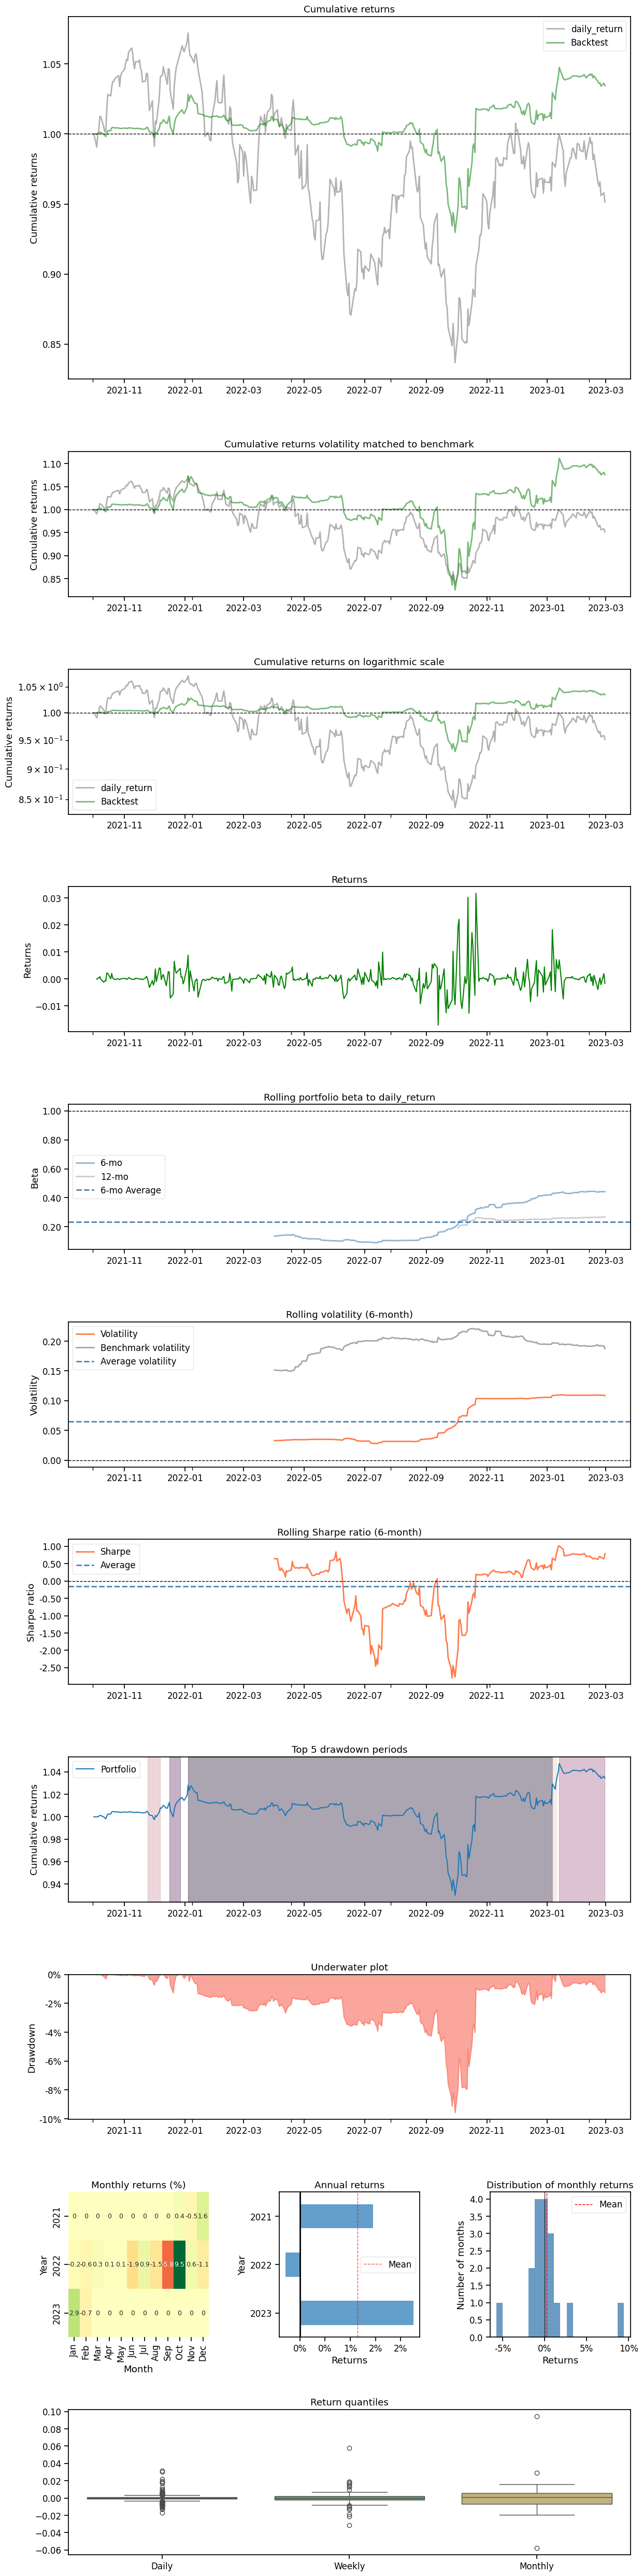

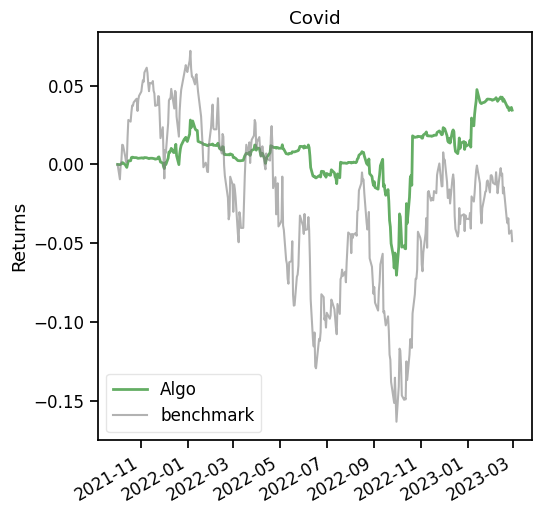

In [43]:
print("==============Compare to DJIA===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX

if if_using_ppo:
  backtest_plot(df_account_value_ppo,
              baseline_ticker = '^DJI',
              baseline_start = TEST_START_DATE,
              baseline_end = TEST_END_DATE)


## Run Ensemble from 2021 to 2023
- "Deep Reinforcement Learning for Automated Stock Trading: An Ensemble Strategy" (ICAIF, 2020)

In [30]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.config_tickers import DOW_30_TICKER
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent,DRLEnsembleAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline

from pprint import pprint

import sys
sys.path.append("../FinRL-Library")

import itertools

In [38]:
import os
from pathlib import Path
from finrl import config
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer

# 1. Создаем директории для результатов ансамбля
BASE_DIR = "/content/drive/MyDrive/RL"
ENSEMBLE_DIR = f"{BASE_DIR}/ensemble_results"

# Создаем поддиректории для ансамбля
ensemble_dirs = [
    f"{ENSEMBLE_DIR}/trained_models",
    f"{ENSEMBLE_DIR}/validation_results",
    f"{ENSEMBLE_DIR}/trading_results",
    f"{ENSEMBLE_DIR}/logs",
    f"{ENSEMBLE_DIR}/plots"
]

for dir_path in ensemble_dirs:
    os.makedirs(dir_path, exist_ok=True)
    print(f"Создана директория: {dir_path}")

print(f"\nВсе директории ансамбля созданы в: {ENSEMBLE_DIR}")

# 2. Создаем функцию для обновления config.RESULTS_DIR
# FinRL использует config.RESULTS_DIR для сохранения результатов
config.RESULTS_DIR = ENSEMBLE_DIR
print(f"config.RESULTS_DIR установлен в: {config.RESULTS_DIR}")

Создана директория: /content/drive/MyDrive/RL/ensemble_results/trained_models
Создана директория: /content/drive/MyDrive/RL/ensemble_results/validation_results
Создана директория: /content/drive/MyDrive/RL/ensemble_results/trading_results
Создана директория: /content/drive/MyDrive/RL/ensemble_results/logs
Создана директория: /content/drive/MyDrive/RL/ensemble_results/plots

Все директории ансамбля созданы в: /content/drive/MyDrive/RL/ensemble_results
config.RESULTS_DIR установлен в: /content/drive/MyDrive/RL/ensemble_results


In [31]:
df = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TEST_END_DATE,
                     ticker_list = DOW_30_TICKER).fetch_data()


[*********************100%***********************]  1 of 1 completed/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
[*********************100%***********************]  1 of 1 completed/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent da

Shape of DataFrame:  (93702, 8)


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Simple Preprocessing

In [32]:
INDICATORS = ['macd',
              'rsi_30',
              'cci_30',
              'dx_30']
fe = FeatureEngineer(use_technical_indicator=True,
                     tech_indicator_list = INDICATORS,
                     use_turbulence=True,
                     user_defined_feature = False)

processed = fe.preprocess_data(df)
processed = processed.copy()
processed = processed.fillna(0)
processed = processed.replace(np.inf,0)

Successfully added technical indicators


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

Successfully added turbulence index


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Design Environment

In [33]:
stock_dimension = len(processed.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 28, State Space: 169


In [34]:
env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "buy_cost_pct": 0.001,
    "sell_cost_pct": 0.001,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4,
    "print_verbosity":5

}

In [35]:
rebalance_window = 63 # rebalance_window is the number of days to retrain the model
validation_window = 63 # validation_window is the number of days to do validation and trading (e.g. if validation_window=63, then both validation and trading period will be 63 days)

ensemble_agent = DRLEnsembleAgent(df=processed,
                 train_period=(TRAIN_START_DATE,TRAIN_END_DATE),
                 val_test_period=(TEST_START_DATE,TEST_END_DATE),
                 rebalance_window=rebalance_window,
                 validation_window=validation_window,
                 **env_kwargs)

In [36]:
A2C_model_kwargs = {
                    'n_steps': 5,
                    'ent_coef': 0.005,
                    'learning_rate': 0.0007
                    }

PPO_model_kwargs = {
                    "ent_coef":0.01,
                    "n_steps": 2048,
                    "learning_rate": 0.00025,
                    "batch_size": 128
                    }

DDPG_model_kwargs = {
                      #"action_noise":"ornstein_uhlenbeck",
                      "buffer_size": 10_000,
                      "learning_rate": 0.0005,
                      "batch_size": 64
                    }

SAC_model_kwargs = {
    "batch_size": 64,
    "buffer_size": 100000,
    "learning_rate": 0.0001,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
}

TD3_model_kwargs = {"batch_size": 100, "buffer_size": 1000000, "learning_rate": 0.0001}




timesteps_dict = {'a2c' : 10_000,
                 'ppo' : 10_000,
                 'ddpg' : 10_000,
                 'sac' : 10_000,
                 'td3' : 10_000
                 }

In [40]:
import os

# Создаем директорию results в текущей рабочей директории
os.makedirs("results", exist_ok=True)
print(f"Создана директория: {os.path.abspath('results')}")

# Также убедимся, что config.RESULTS_DIR существует
os.makedirs(config.RESULTS_DIR, exist_ok=True)
print(f"config.RESULTS_DIR: {config.RESULTS_DIR}")

Создана директория: /content/results
config.RESULTS_DIR: /content/drive/MyDrive/RL/ensemble_results


In [41]:
df_summary = ensemble_agent.run_ensemble_strategy(A2C_model_kwargs,
                                                 PPO_model_kwargs,
                                                 DDPG_model_kwargs,
                                                 SAC_model_kwargs,
                                                 TD3_model_kwargs,
                                                 timesteps_dict)

Output hidden; open in https://colab.research.google.com to view.

## Backtest Ensemble

In [44]:
unique_trade_date = processed[(processed.date > TEST_START_DATE)&(processed.date <= TEST_END_DATE)].date.unique()

In [85]:
df_trade_date = pd.DataFrame({'datadate':unique_trade_date})

df_account_value_ensemble=pd.DataFrame()
for i in range(rebalance_window+validation_window, len(unique_trade_date)+1,rebalance_window):
    temp = pd.read_csv('/content/results/account_value_trade_{}_{}.csv'.format('ensemble',i))
    df_account_value_ensemble = pd.concat([df_account_value_ensemble, temp], ignore_index=True)
sharpe=(252**0.5)*df_account_value_ensemble.account_value.pct_change(1).mean()/df_account_value_ensemble.account_value.pct_change(1).std()
print('Sharpe Ratio: ',sharpe)
df_account_value_ensemble=df_account_value_ensemble.join(df_trade_date.reset_index(drop=True))

Sharpe Ratio:  -0.1808079231578458


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [88]:
df_account_value_ensemble.head()

,account_value,date,daily_return,datadate
0,1.000000e+06,2022-01-03,NaN,2021-10-04
1,1.002023e+06,2022-01-04,0.002023,2021-10-05
2,9.928169e+05,2022-01-05,-0.009187,2021-10-06
3,9.920638e+05,2022-01-06,-0.000759,2021-10-07
4,9.909309e+05,2022-01-07,-0.001142,2021-10-08


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [57]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_ensemble = backtest_stats(account_value=df_account_value_ensemble)
perf_stats_ensemble = pd.DataFrame(perf_stats_ensemble)

==============Get Backtest Results===========
Annual return         -0.052314
Cumulative returns    -0.052314
Annual volatility      0.194319
Sharpe ratio          -0.180808
Calmar ratio          -0.275994
Stability              0.020580
Max drawdown          -0.189548
Omega ratio            0.970744
Sortino ratio         -0.254999
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.089603
Daily value at risk   -0.024621
dtype: float64


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [112]:
df_account_value_ensemble.head() # date + 63 days to begin trading

,account_value,date,daily_return,datadate
0,1.000000e+06,2022-01-03,NaN,2021-10-04
1,1.002023e+06,2022-01-04,0.002023,2021-10-05
2,9.928169e+05,2022-01-05,-0.009187,2021-10-06
3,9.920638e+05,2022-01-06,-0.000759,2021-10-07
4,9.909309e+05,2022-01-07,-0.001142,2021-10-08


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [113]:
df_account_value_ensemble.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   account_value  252 non-null    float64
 1   date           252 non-null    object 
 2   daily_return   248 non-null    float64
 3   datadate       252 non-null    object 
dtypes: float64(2), object(2)
memory usage: 8.0+ KB


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [116]:
df_account_value_ensemble['date'] = pd.to_datetime(df_account_value_ensemble['date'])

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [117]:
df_result_ensemble = (
    df_account_value_ensemble.set_index(df_account_value_ensemble.columns[1])
)

In [122]:
df_result_ensemble.head()

,account_value,daily_return,datadate
date,,,
2022-01-03,1.000000e+06,NaN,2021-10-04
2022-01-04,1.002023e+06,0.002023,2021-10-05
2022-01-05,9.928169e+05,-0.009187,2021-10-06
2022-01-06,9.920638e+05,-0.000759,2021-10-07
2022-01-07,9.909309e+05,-0.001142,2021-10-08


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [123]:
df_result_ensemble.tail()

,account_value,daily_return,datadate
date,,,
2022-12-27,951351.888855,0.001663,2022-09-27
2022-12-28,940366.352126,-0.011547,2022-09-28
2022-12-29,948939.483799,0.009117,2022-09-29
2022-12-30,945122.061901,-0.004023,2022-09-30
2023-01-03,947685.775762,0.002713,2022-10-03


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [127]:
test_df_account_value_a2c = df_account_value_a2c[(df_account_value_a2c['date']>='2022-01-03') & (df_account_value_a2c['date']<='2023-01-03')]
test_df_account_value_ppo = df_account_value_ppo[(df_account_value_ppo['date']>='2022-01-03') & (df_account_value_ppo['date']<='2023-01-03')]
test_df_account_value_ddpg = df_account_value_ddpg[(df_account_value_ddpg['date']>='2022-01-03') & (df_account_value_ddpg['date']<='2023-01-03')]

In [134]:
df_dji = df_dji.reset_index()
df_dji = df_dji[(df_dji['date']>='2022-01-03') & (df_dji['date']<='2023-01-03')]
df_dji = df_dji.set_index(df_dji.columns[0])
df_dji.head()

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


,dji
date,
2022-01-03,1.065798e+06
2022-01-04,1.072049e+06
2022-01-05,1.060614e+06
2022-01-06,1.055642e+06
2022-01-07,1.055502e+06


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [220]:
df_dji = df_dji.set_index(df_dji.columns[0])

In [221]:
df_result_a2c = (
    test_df_account_value_a2c.set_index(test_df_account_value_a2c.columns[0])

)
df_result_ddpg = (
    test_df_account_value_ddpg.set_index(test_df_account_value_ddpg.columns[0])

)
df_result_ppo = (
    test_df_account_value_ppo.set_index(test_df_account_value_ppo.columns[0])

)


result = pd.DataFrame(
    {
        "a2c": df_result_a2c["account_value"],
        "ddpg": df_result_ddpg["account_value"],
        "ppo": df_result_ppo["account_value"],
        "dji": df_dji["dji"],
        "ensemble": df_result_ensemble["account_value"]
    }
)

In [207]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
import numpy as np

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['figure.figsize'] = (16, 8)
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


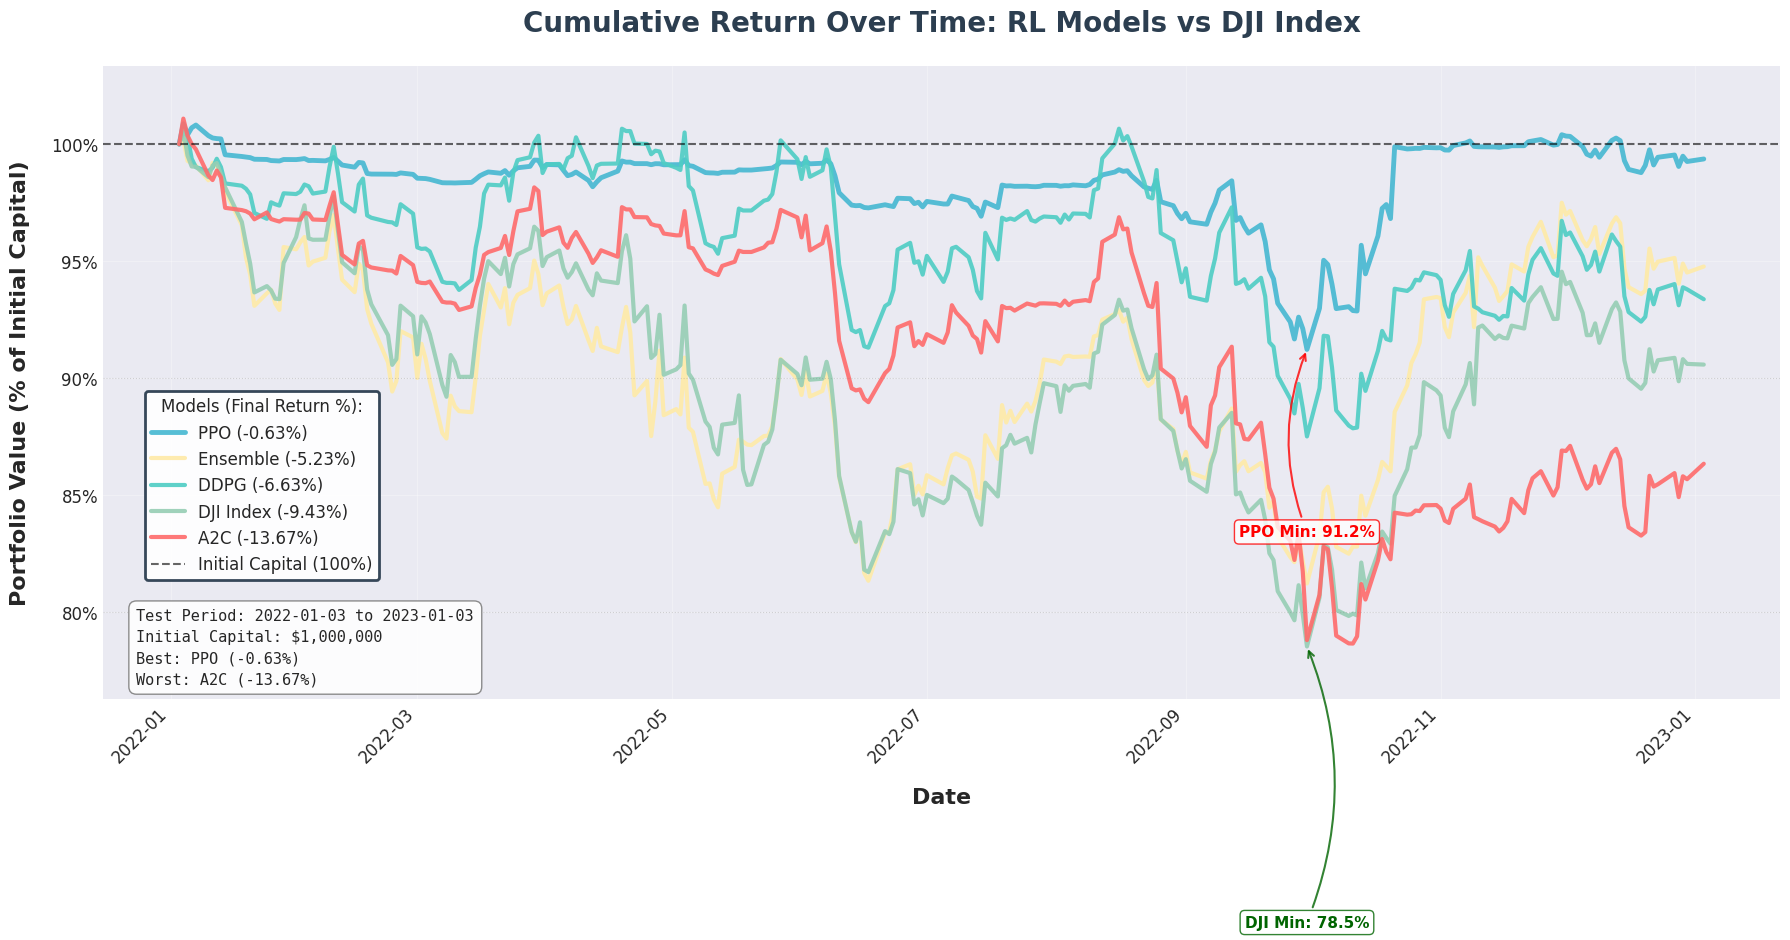

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


✓ График сохранен: /content/drive/MyDrive/RL/visualizations/cumulative_returns_final.png
  Размер: 18x10 inches
  Разрешение: 300 DPI
✓ Векторная версия сохранена: /content/drive/MyDrive/RL/visualizations/cumulative_returns_final.svg


In [217]:
# Ячейка: Создание основного графика (только cumulative returns)
fig, ax = plt.subplots(figsize=(18, 10))

# Цветовая схема для моделей (старая)
model_colors = {
    'a2c': '#FF6B6B',      # Красный
    'ddpg': '#4ECDC4',     # Бирюзовый
    'ppo': '#45B7D1',      # Голубой
    'dji': '#96CEB4',      # Зеленый
    'ensemble': '#FFEAA7'  # Желтый
}

model_names_full = {
    'a2c': 'A2C',
    'ddpg': 'DDPG',
    'ppo': 'PPO',
    'dji': 'DJI Index',
    'ensemble': 'Ensemble'
}

# Убедимся, что индексы в datetime формате
if hasattr(result.index, 'dtype') and result.index.dtype == 'object':
    result.index = pd.to_datetime(result.index)

# Стили линий (все сплошные линии)
line_styles = {
    'a2c': '-',
    'ddpg': '-',
    'ppo': '-',
    'dji': '-',
    'ensemble': '-'
}

# Толщина линий (все линии толстые)
line_widths = {
    'a2c': 3.0,
    'ddpg': 3.0,
    'ppo': 3.5,  # PPO - немного толще как лучшая модель
    'dji': 3.0,
    'ensemble': 3.0
}

# Сортируем модели по итоговой доходности (для порядка в легенде)
final_returns = {}
for model in result.columns:
    if len(result[model].dropna()) > 0:
        final_value = result[model].dropna().iloc[-1]
        initial_value = result[model].dropna().iloc[0]
        if initial_value != 0:
            final_returns[model] = (final_value / initial_value - 1) * 100

models_sorted = sorted(final_returns.keys(), key=lambda x: final_returns[x], reverse=True)

# Рисуем линии в порядке убывания доходности
for model in models_sorted:
    data = result[model].dropna()
    if len(data) > 0:
        # Нормализуем к начальному капиталу 1,000,000 для процентного отображения
        normalized_data = data / data.iloc[0] * 100

        ax.plot(data.index, normalized_data,
                label=f"{model_names_full[model]} ({final_returns.get(model, 0):.2f}%)",
                color=model_colors[model],
                linestyle=line_styles.get(model, '-'),
                linewidth=line_widths.get(model, 3),
                alpha=0.9)

# Настройка графика
ax.set_title('Cumulative Return Over Time: RL Models vs DJI Index',
              fontsize=20, fontweight='bold', pad=25, color='#2c3e50')

ax.set_ylabel('Portfolio Value (% of Initial Capital)',
               fontsize=16, fontweight='bold', labelpad=15)

ax.set_xlabel('Date', fontsize=16, fontweight='bold', labelpad=15)

# Форматирование оси Y в процентах
def percent_formatter(x, pos):
    return f'{x:.0f}%'

ax.yaxis.set_major_formatter(FuncFormatter(percent_formatter))

# Добавляем горизонтальную линию на уровне 100% (начальный капитал)
ax.axhline(y=100, color='black', linestyle='--', linewidth=1.5, alpha=0.6,
            label='Initial Capital (100%)')

# Добавляем фон с горизонтальными уровнями для лучшей читаемости
for level in [80, 90, 100, 110, 120]:
    if level == 100:
        continue  # Уже нарисовали выше
    ax.axhline(y=level, color='gray', linestyle=':', linewidth=0.8, alpha=0.3)

# Легенда
legend = ax.legend(loc='upper left', fontsize=12, frameon=True,
                   framealpha=0.95, edgecolor='#2c3e50',
                   facecolor='white', title='Models (Final Return %):',
                   title_fontsize=12, bbox_to_anchor=(0.02, 0.5), )
legend.get_frame().set_linewidth(2)

# Сетка
ax.grid(True, alpha=0.3, linestyle='-', which='both')

# Добавляем аннотацию только для минимума PPO
if 'ppo' in result.columns:
    ppo_data = result['ppo'].dropna()
    if len(ppo_data) > 0:
        normalized_ppo = ppo_data / ppo_data.iloc[0] * 100
        min_idx = normalized_ppo.idxmin()
        min_value = normalized_ppo.min()

        # Аннотация для минимума PPO
        ax.annotate(f'PPO Min: {min_value:.1f}%',
                   xy=(min_idx, min_value),
                   xytext=(min_idx, min_value - 8),
                   arrowprops=dict(arrowstyle='->',
                                  color='red',
                                  alpha=0.8,
                                  lw=1.5,
                                  connectionstyle="arc3,rad=-0.2"),
                   fontsize=11,
                   fontweight='bold',
                   color='red',
                   ha='center',
                   bbox=dict(boxstyle="round,pad=0.3",
                            facecolor="white",
                            alpha=0.8,
                            edgecolor="red"))

# Также можно добавить аннотацию для минимума DJI для сравнения
if 'dji' in result.columns:
    dji_data = result['dji'].dropna()
    if len(dji_data) > 0:
        normalized_dji = dji_data / dji_data.iloc[0] * 100
        min_idx_dji = normalized_dji.idxmin()
        min_value_dji = normalized_dji.min()

        # Аннотация для минимума DJI
        ax.annotate(f'DJI Min: {min_value_dji:.1f}%',
                   xy=(min_idx_dji, min_value_dji),
                   xytext=(min_idx_dji, min_value_dji - 12),
                   arrowprops=dict(arrowstyle='->',
                                  color='darkgreen',
                                  alpha=0.8,
                                  lw=1.5,
                                  connectionstyle="arc3,rad=0.2"),
                   fontsize=11,
                   fontweight='bold',
                   color='darkgreen',
                   ha='center',
                   bbox=dict(boxstyle="round,pad=0.3",
                            facecolor="white",
                            alpha=0.8,
                            edgecolor="darkgreen"))

# Добавляем информационный блок
if len(result) > 0:
    start_date = result.index[0].strftime('%Y-%m-%d')
    end_date = result.index[-1].strftime('%Y-%m-%d')

    info_text = f"Test Period: {start_date} to {end_date}\n"
    info_text += f"Initial Capital: $1,000,000\n"

    # Добавляем лучшую и худшую модели
    if final_returns:
        best_model = max(final_returns.items(), key=lambda x: x[1])
        worst_model = min(final_returns.items(), key=lambda x: x[1])

        info_text += f"Best: {model_names_full.get(best_model[0], best_model[0])} ({best_model[1]:.2f}%)\n"
        info_text += f"Worst: {model_names_full.get(worst_model[0], worst_model[0])} ({worst_model[1]:.2f}%)"

    props = dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='gray', pad=0.5)
    ax.text(0.02, 0.02, info_text, transform=ax.transAxes, fontsize=11,
        verticalalignment='bottom', bbox=props, fontfamily='monospace',
        linespacing=1.5)

# Поворот дат на оси X для лучшей читаемости
plt.xticks(rotation=45, ha='right')

# Устанавливаем отступы для осей
ax.yaxis.set_tick_params(labelsize=12)
ax.xaxis.set_tick_params(labelsize=12)

# Автоматическое масштабирование оси Y с небольшим запасом
if len(result) > 0:
    all_values = []
    for model in result.columns:
        data = result[model].dropna()
        if len(data) > 0:
            normalized = data / data.iloc[0] * 100
            all_values.extend(normalized.values)

    if all_values:
        y_min = min(all_values)
        y_max = max(all_values)
        y_padding = (y_max - y_min) * 0.1
        ax.set_ylim(y_min - y_padding, y_max + y_padding)

plt.tight_layout()
plt.show()

# Сохранение графика
save_dir = "/content/drive/MyDrive/RL/visualizations"
os.makedirs(save_dir, exist_ok=True)

fig.savefig(f'{save_dir}/cumulative_returns_final.png',
            dpi=300,
            bbox_inches='tight',
            facecolor='white',
            edgecolor='none')

print(f"✓ График сохранен: {save_dir}/cumulative_returns_final.png")
print(f"  Размер: {fig.get_size_inches()[0]:.0f}x{fig.get_size_inches()[1]:.0f} inches")
print(f"  Разрешение: 300 DPI")

# Также сохраняем в SVG для векторного формата
fig.savefig(f'{save_dir}/cumulative_returns_final.svg',
            format='svg',
            bbox_inches='tight',
            facecolor='white',
            edgecolor='none')
print(f"✓ Векторная версия сохранена: {save_dir}/cumulative_returns_final.svg")

# Comparison

In [167]:
perf_stats_ensemble

,0
Annual return,-0.052314
Cumulative returns,-0.052314
Annual volatility,0.194319
Sharpe ratio,-0.180808
Calmar ratio,-0.275994
Stability,0.020580
Max drawdown,-0.189548
Omega ratio,0.970744
Sortino ratio,-0.254999
Skew,NaN


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [166]:
perf_stats_ppo_test = backtest_stats(account_value=test_df_account_value_ppo)
perf_stats_ppo_test = pd.DataFrame(perf_stats_ppo_test)

perf_stats_ddpg_test = backtest_stats(account_value=test_df_account_value_ddpg)
perf_stats_ddpg_test = pd.DataFrame(perf_stats_ddpg_test)

perf_stats_a2c_test = backtest_stats(account_value=test_df_account_value_a2c)
perf_stats_a2c_test = pd.DataFrame(perf_stats_a2c_test)



Annual return         -0.006314
Cumulative returns    -0.006314
Annual volatility      0.078014
Sharpe ratio          -0.042950
Calmar ratio          -0.065968
Stability              0.042075
Max drawdown          -0.095708
Omega ratio            0.989385
Sortino ratio         -0.073924
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.782918
Daily value at risk   -0.009842
dtype: float64
Annual return         -0.066313
Cumulative returns    -0.066313
Annual volatility      0.152835
Sharpe ratio          -0.374481
Calmar ratio          -0.507087
Stability              0.368359
Max drawdown          -0.130772
Omega ratio            0.935535
Sortino ratio         -0.519109
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.963548
Daily value at risk   -0.019483
dtype: float64
Annual return         -0.136674
Cumulative returns    -0.136674
Annual volatility      0.153810
Sharpe ratio          -0.882178
Calmar rat

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [149]:
# df_dji = df_dji.reset_index()

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [165]:
perf_stats_dji_test = backtest_stats(account_value=df_dji, value_col_name='dji')
perf_stats_dji_test = pd.DataFrame(perf_stats_dji_test)

Annual return         -0.094265
Cumulative returns    -0.094265
Annual volatility      0.198105
Sharpe ratio          -0.402922
Calmar ratio          -0.429633
Stability              0.232976
Max drawdown          -0.219408
Omega ratio            0.935766
Sortino ratio         -0.560953
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.013833
Daily value at risk   -0.025276
dtype: float64


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [168]:
all_models = {
    'PPO': perf_stats_all_ppo,
    'DDPG': perf_stats_all_ddpg,
    'A2C': perf_stats_all_a2c,
    'Ensemble': perf_stats_ensemble,
    'DJI': perf_stats_dji
}

In [169]:
summary_metrics = pd.DataFrame()
key_metrics = [
    'Cumulative returns',
    'Annual return',
    'Annual volatility',
    'Sharpe ratio',
    'Max drawdown'
]

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [170]:
for model_name, model_stats in all_models.items():
    if model_stats is not None:

        if isinstance(model_stats, pd.DataFrame):
            if model_stats.shape[1] == 1:
                model_series = model_stats.iloc[:, 0]
            else:
                model_series = model_stats.iloc[:, 0]
        elif isinstance(model_stats, pd.Series):
            model_series = model_stats
        else:
            print(f"  Пропускаю {model_name} - неподдерживаемый формат")
            continue

        metrics_dict = {}

        for metric in key_metrics:
            if metric in model_series.index:
                metrics_dict[metric] = model_series[metric]
            else:
                found = False
                for idx in model_series.index:
                    if metric.lower() in str(idx).lower():
                        metrics_dict[metric] = model_series[idx]
                        found = True
                        break
                if not found:
                    metrics_dict[metric] = np.nan
                    print(f"  Метрика '{metric}' не найдена в {model_name}")

        summary_metrics[model_name] = pd.Series(metrics_dict)

summary_metrics = summary_metrics.T

print(summary_metrics)

Обрабатываю PPO...
Обрабатываю DDPG...
Обрабатываю A2C...
Обрабатываю Ensemble...
Обрабатываю DJI...
          Cumulative returns  Annual return  Annual volatility  Sharpe ratio  \
PPO                 0.034433       0.024392           0.070495      0.377738   
DDPG                0.007188       0.005111           0.145236      0.107686   
A2C                -0.077870      -0.056077           0.142616     -0.334477   
Ensemble           -0.052314      -0.052314           0.194319     -0.180808   
DJI                -0.041874      -0.030075           0.181774     -0.077727   

          Max drawdown  
PPO          -0.095708  
DDPG         -0.130772  
A2C          -0.222106  
Ensemble     -0.189548  
DJI          -0.219408  


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [172]:
summary_metrics.to_csv("/content/drive/MyDrive/RL/results/summary_metrics.csv", index=False)

In [178]:
summary_metrics.sort_values(by="Cumulative returns", ascending=False)

,Cumulative returns,Annual return,Annual volatility,Sharpe ratio,Max drawdown
PPO,0.034433,0.024392,0.070495,0.377738,-0.095708
DDPG,0.007188,0.005111,0.145236,0.107686,-0.130772
DJI,-0.041874,-0.030075,0.181774,-0.077727,-0.219408
Ensemble,-0.052314,-0.052314,0.194319,-0.180808,-0.189548
A2C,-0.077870,-0.056077,0.142616,-0.334477,-0.222106


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [176]:
print("Best Model By Metric")
for metric in summary_metrics.columns:
    if metric in ['Annual volatility', 'Max drawdown']:
        best_model = summary_metrics[metric].idxmin()
        best_value = summary_metrics.loc[best_model, metric]
        if 'volatility' in metric.lower() or 'drawdown' in metric.lower():
            print(f"{metric}: {best_model} ({best_value*100:.2f}%)")
        else:
            print(f"{metric}: {best_model} ({best_value:.4f})")
    else:
        # Для остальных метрик чем больше, тем лучше
        best_model = summary_metrics[metric].idxmax()
        best_value = summary_metrics.loc[best_model, metric]
        if 'returns' in metric.lower() or 'return' in metric.lower():
            print(f"{metric}: {best_model} ({best_value*100:.2f}%)")
        else:
            print(f"{metric}: {best_model} ({best_value:.4f})")

Best Model By Metric
Cumulative returns: PPO (3.44%)
Annual return: PPO (2.44%)
Annual volatility: PPO (7.05%)
Sharpe ratio: PPO (0.3777)
Max drawdown: A2C (-22.21%)


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [183]:
import shutil
target_folder = '/content/drive/MyDrive/RL/ensemble_results'
# Папки для копирования
folders_to_copy = [
    '/content/results',
    '/content/tensorboard_log',
    '/content/trained_models'
]

print(f"Копирование результатов в: {target_folder}")

for source_folder in folders_to_copy:
    if os.path.exists(source_folder):
        folder_name = os.path.basename(source_folder)
        target_path = os.path.join(target_folder, folder_name)

        print(f"\nКопирую {source_folder}...")

        # Копируем всю папку с содержимым
        shutil.copytree(source_folder, target_path)
        print(f"  ✓ Скопировано в {target_path}")
    else:
        print(f"\n⚠ Папка {source_folder} не существует")

print(f"\n✅ Все результаты сохранены в Google Drive: {target_folder}")

Копирование результатов в: /content/drive/MyDrive/RL/ensemble_results

Копирую /content/results...
  ✓ Скопировано в /content/drive/MyDrive/RL/ensemble_results/results

Копирую /content/tensorboard_log...
  ✓ Скопировано в /content/drive/MyDrive/RL/ensemble_results/tensorboard_log

Копирую /content/trained_models...
  ✓ Скопировано в /content/drive/MyDrive/RL/ensemble_results/trained_models

✅ Все результаты сохранены в Google Drive: /content/drive/MyDrive/RL/ensemble_results


In [197]:
# Ячейка 1: Подготовка данных и импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from matplotlib.patches import Circle, Wedge, Rectangle

# Настройка стиля
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['font.family'] = 'DejaVu Sans'

# Переименование столбцов
df = summary_metrics.copy()

# Переименовываем столбцы в более читаемый формат
column_rename = {
    'Cumulative returns': 'Cumulative Return',
    'Annual return': 'Annual Return',
    'Annual volatility': 'Annual Volatility',
    'Sharpe ratio': 'Sharpe Ratio',
    'Max drawdown': 'Max Drawdown'
}
metrics = ['Cumulative Return', 'Annual Return', 'Annual Volatility', 'Sharpe Ratio', 'Max Drawdown']
# Применяем переименование
df = df.rename(columns=column_rename)

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


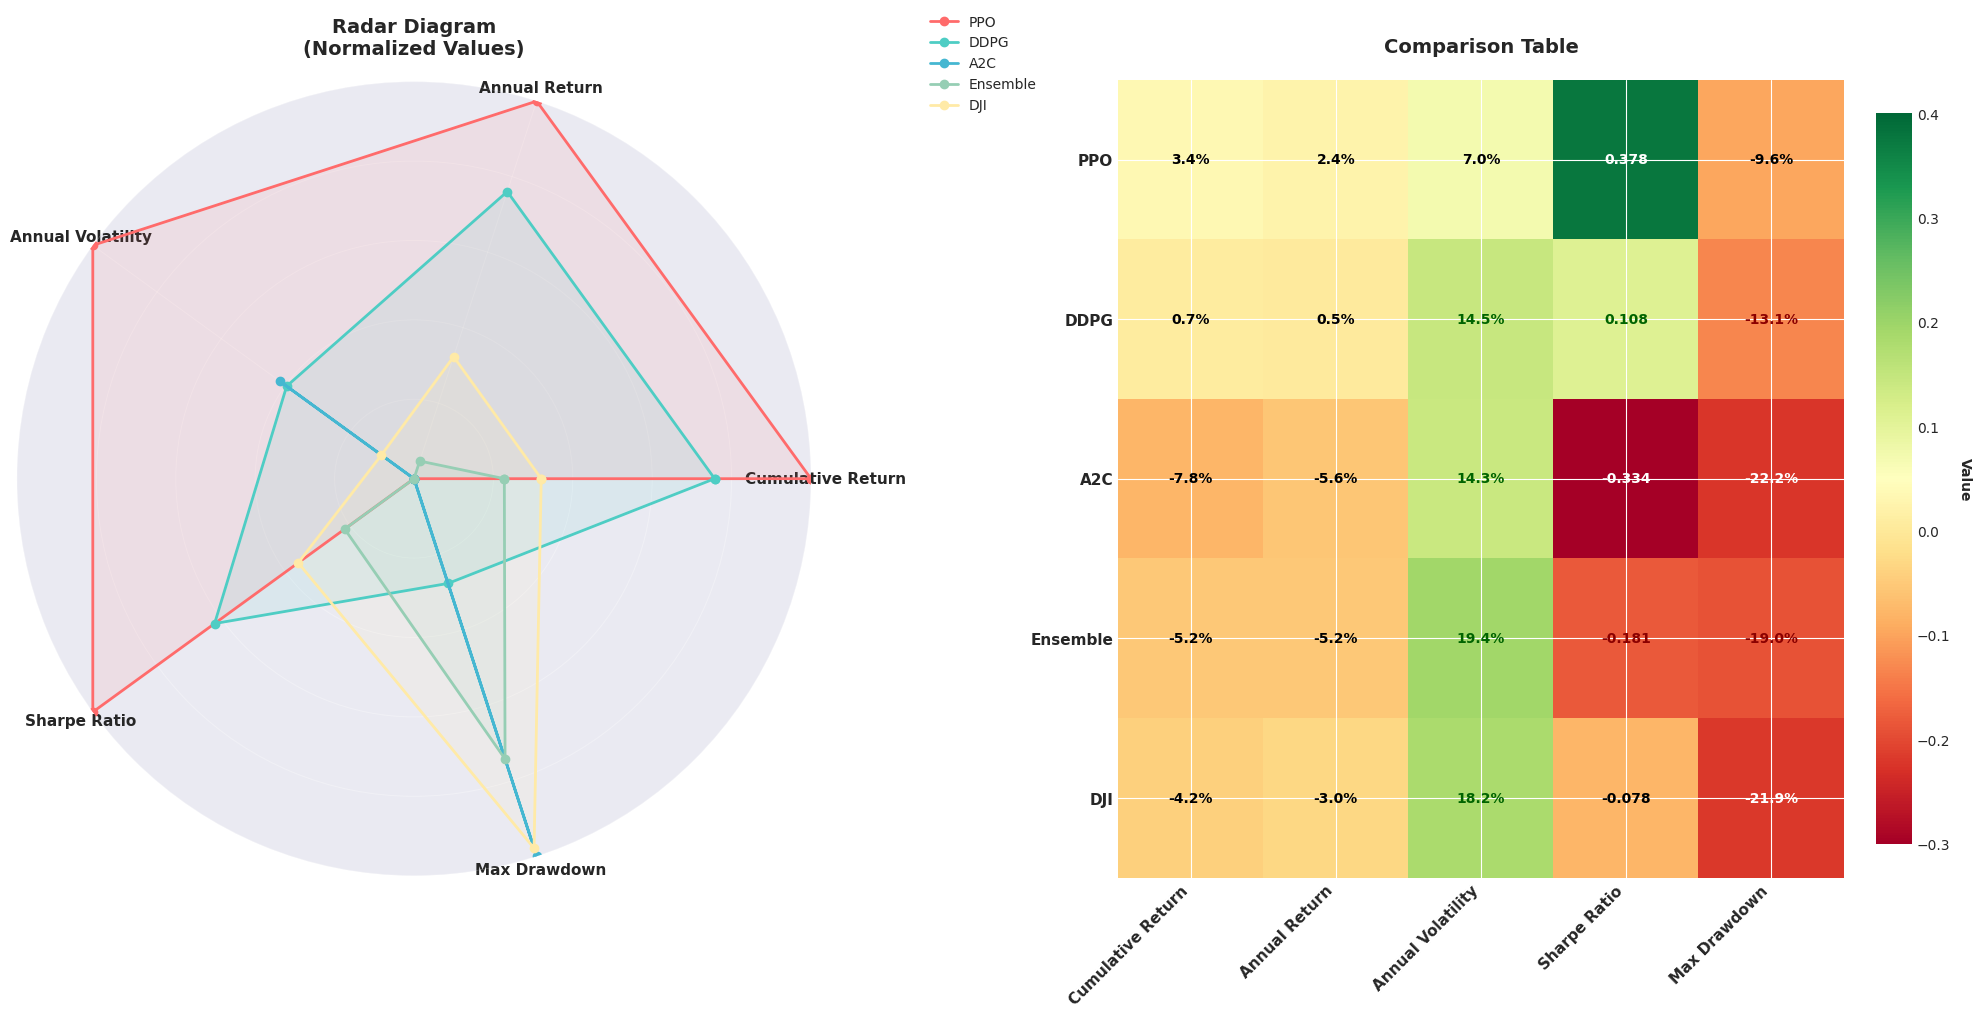

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [205]:
# Ячейка 2: Создание комплексной визуализации "Радарная диаграмма + Heatmap"
fig = plt.figure(figsize=(20, 10))

# 1. ЛЕВАЯ ЧАСТЬ: Радарная диаграмма
ax1 = plt.subplot(1, 2, 1, polar=True)

# Нормализуем данные для радарной диаграммы
def normalize_data(series):
    """Нормализует данные в диапазон 0-1"""
    # Для Sharpe Ratio и доходностей - чем больше, тем лучше
    # Для волатильности и просадки - чем меньше, тем лучше
    result = series.copy()

    for i, metric in enumerate(metrics):
        if metric in ['Annual Volatility', 'Max Drawdown']:
            # Инвертируем: чем меньше значение, тем больше нормализованное
            min_val = df[metric].min()
            max_val = df[metric].max()
            if max_val != min_val:
                result[i] = 1 - (series[i] - min_val) / (max_val - min_val)
            else:
                result[i] = 0.5
        else:
            # Прямая нормализация
            min_val = df[metric].min()
            max_val = df[metric].max()
            if max_val != min_val:
                result[i] = (series[i] - min_val) / (max_val - min_val)
            else:
                result[i] = 0.5
    return result

# Углы для каждой метрики
angles = np.linspace(0, 2*np.pi, len(metrics), endpoint=False).tolist()
angles += angles[:1]  # Замыкаем круг

# Цветовая схема
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7']
models = df.index.tolist()

# Рисуем каждую модель
for idx, model in enumerate(models):
    values = normalize_data(df.loc[model].values).tolist()
    values += values[:1]  # Замыкаем круг

    ax1.plot(angles, values, 'o-', linewidth=2, label=model, color=colors[idx])
    ax1.fill(angles, values, alpha=0.1, color=colors[idx])

# Настройка радарной диаграммы
ax1.set_xticks(angles[:-1])
ax1.set_xticklabels(metrics, fontsize=11, fontweight='bold')
ax1.set_yticklabels([])
ax1.set_ylim(0, 1)
ax1.grid(True, alpha=0.3)
ax1.set_title('Radar Diagram\n(Normalized Values)',
              fontsize=14, fontweight='bold', pad=20)

# Добавляем легенду
ax1.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=10)

# 2. ПРАВАЯ ЧАСТЬ: Heatmap с аннотациями
ax2 = plt.subplot(1, 2, 2)

# Создаем heatmap с кастомной цветовой картой
heatmap_data = df.copy()

# Создаем кастомную цветовую карту для heatmap
cmap = plt.cm.RdYlGn

# Отображаем heatmap
im = ax2.imshow(heatmap_data.values, cmap=cmap, aspect='auto', vmin=-0.3, vmax=0.4)

# Добавляем аннотации
for i in range(len(models)):
    for j in range(len(metrics)):
        value = heatmap_data.iloc[i, j]

        # Форматирование значения
        if metrics[j] in ['Cumulative Return', 'Annual Return', 'Annual Volatility', 'Max Drawdown']:
            text = f"{value*100:.1f}%"
        else:
            text = f"{value:.3f}"

        # Выбор цвета текста в зависимости от фона
        if abs(value) < 0.1:  # Для значений близких к 0
            text_color = 'black'
        elif value > 0:
            text_color = 'darkgreen' if value < 0.2 else 'white'
        else:
            text_color = 'darkred' if value > -0.2 else 'white'

        ax2.text(j, i, text, ha='center', va='center',
                color=text_color, fontweight='bold', fontsize=10)

# Настройка осей
ax2.set_xticks(range(len(metrics)))
ax2.set_xticklabels(metrics, rotation=45, ha='right', fontsize=11, fontweight='bold')
ax2.set_yticks(range(len(models)))
ax2.set_yticklabels(models, fontsize=11, fontweight='bold')

# Добавляем цветовую шкалу
cbar = plt.colorbar(im, ax=ax2, fraction=0.046, pad=0.04)
cbar.set_label('Value', rotation=270, labelpad=15, fontweight='bold')

ax2.set_title('Comparison Table',
              fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()

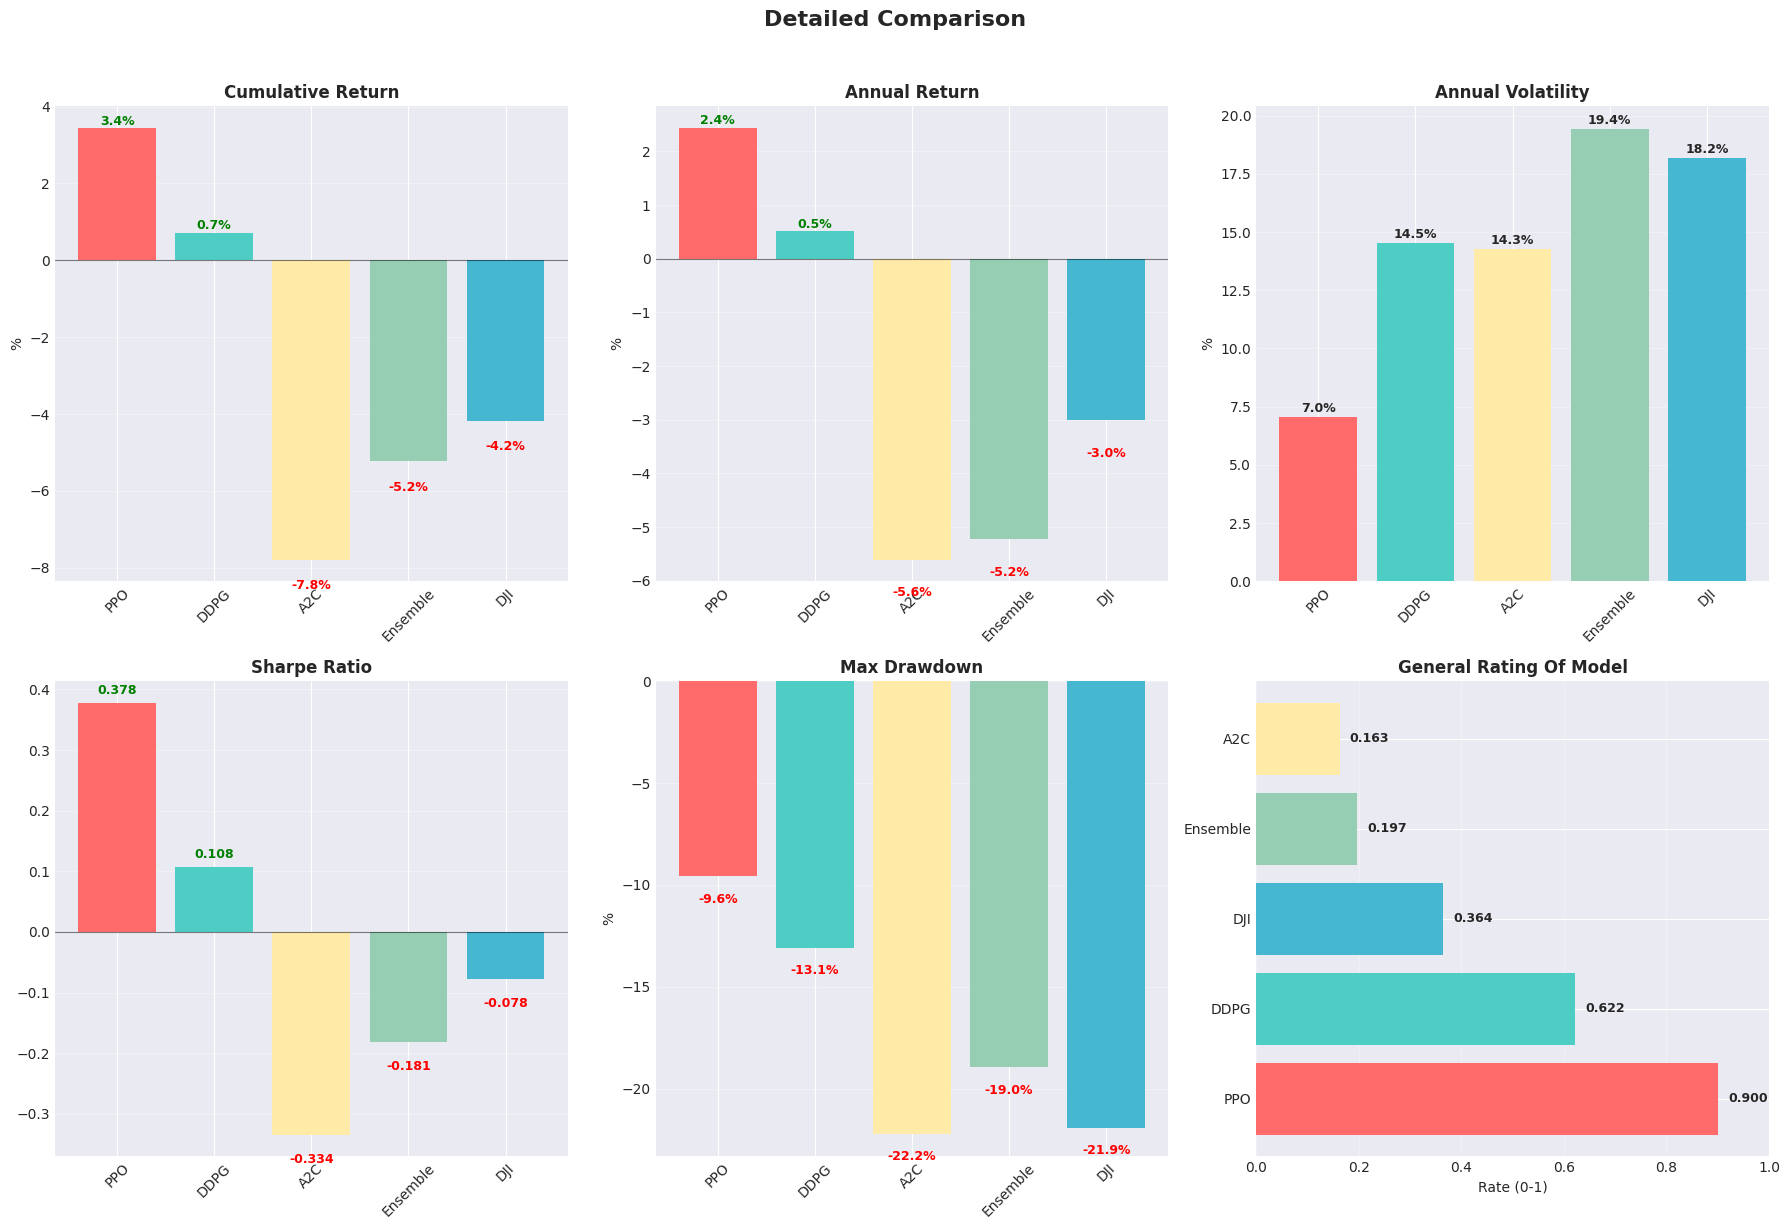

In [202]:
# Ячейка 3: Дополнительная визуализация - Барчарт с группировкой
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Detailed Comparison',
             fontsize=16, fontweight='bold', y=1.02)

# Создаем список цветов для моделей
model_colors = {
    'PPO': '#FF6B6B',
    'DDPG': '#4ECDC4',
    'DJI': '#45B7D1',
    'Ensemble': '#96CEB4',
    'A2C': '#FFEAA7'
}

# 1. Cumulative Return
ax = axes[0, 0]
values = df['Cumulative Return'] * 100  # В процентах
bars = ax.bar(models, values, color=[model_colors[m] for m in models])
ax.axhline(y=0, color='black', linewidth=0.8, linestyle='-', alpha=0.5)
ax.set_title('Cumulative Return', fontsize=12, fontweight='bold')
ax.set_ylabel('%', fontsize=10)
ax.tick_params(axis='x', rotation=45)
ax.grid(True, alpha=0.3, axis='y')

# Добавляем значения на столбцы
for bar, val in zip(bars, values):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + (0.01 if height >= 0 else -0.5),
            f'{val:.1f}%', ha='center', va='bottom' if height >= 0 else 'top',
            fontsize=9, fontweight='bold',
            color='green' if val > 0 else 'red')

# 2. Annual Return
ax = axes[0, 1]
values = df['Annual Return'] * 100
bars = ax.bar(models, values, color=[model_colors[m] for m in models])
ax.axhline(y=0, color='black', linewidth=0.8, linestyle='-', alpha=0.5)
ax.set_title('Annual Return', fontsize=12, fontweight='bold')
ax.set_ylabel('%', fontsize=10)
ax.tick_params(axis='x', rotation=45)
ax.grid(True, alpha=0.3, axis='y')

for bar, val in zip(bars, values):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + (0.01 if height >= 0 else -0.5),
            f'{val:.1f}%', ha='center', va='bottom' if height >= 0 else 'top',
            fontsize=9, fontweight='bold',
            color='green' if val > 0 else 'red')

# 3. Annual Volatility
ax = axes[0, 2]
values = df['Annual Volatility'] * 100
bars = ax.bar(models, values, color=[model_colors[m] for m in models])
ax.set_title('Annual Volatility', fontsize=12, fontweight='bold')
ax.set_ylabel('%', fontsize=10)
ax.tick_params(axis='x', rotation=45)
ax.grid(True, alpha=0.3, axis='y')

for bar, val in zip(bars, values):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.1,
            f'{val:.1f}%', ha='center', va='bottom',
            fontsize=9, fontweight='bold')

# 4. Sharpe Ratio
ax = axes[1, 0]
values = df['Sharpe Ratio']
bars = ax.bar(models, values, color=[model_colors[m] for m in models])
ax.axhline(y=0, color='black', linewidth=0.8, linestyle='-', alpha=0.5)
ax.set_title('Sharpe Ratio', fontsize=12, fontweight='bold')
ax.tick_params(axis='x', rotation=45)
ax.grid(True, alpha=0.3, axis='y')

for bar, val in zip(bars, values):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + (0.01 if height >= 0 else -0.03),
            f'{val:.3f}', ha='center', va='bottom' if height >= 0 else 'top',
            fontsize=9, fontweight='bold',
            color='green' if val > 0 else 'red')

# 5. Max Drawdown
ax = axes[1, 1]
values = df['Max Drawdown'] * 100
bars = ax.bar(models, values, color=[model_colors[m] for m in models])
ax.set_title('Max Drawdown', fontsize=12, fontweight='bold')
ax.set_ylabel('%', fontsize=10)
ax.tick_params(axis='x', rotation=45)
ax.grid(True, alpha=0.3, axis='y')

for bar, val in zip(bars, values):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height - 0.8,
            f'{val:.1f}%', ha='center', va='top',
            fontsize=9, fontweight='bold',
            color='red')

# 6. Сводный рейтинг (Общий балл)
ax = axes[1, 2]

# Рассчитываем общий балл (чем выше, тем лучше)
# Нормализуем и взвешиваем метрики
normalized_df = df.copy()
for metric in df.columns:
    if metric in ['Annual Volatility', 'Max Drawdown']:
        # Инвертируем: чем меньше, тем лучше
        normalized_df[metric] = 1 - (df[metric] - df[metric].min()) / (df[metric].max() - df[metric].min())
    else:
        normalized_df[metric] = (df[metric] - df[metric].min()) / (df[metric].max() - df[metric].min())

# Взвешивание метрик (можно настроить)
weights = {
    'Cumulative Return': 0.25,
    'Annual Return': 0.25,
    'Annual Volatility': 0.15,
    'Sharpe Ratio': 0.25,
    'Max Drawdown': 0.10
}

# Расчет общего балла
total_scores = {}
for model in models:
    score = 0
    for metric in normalized_df.columns:
        score += normalized_df.loc[model, metric] * weights.get(metric, 0.2)
    total_scores[model] = score

# Сортируем по убыванию
sorted_scores = dict(sorted(total_scores.items(), key=lambda x: x[1], reverse=True))

# Рисуем горизонтальные бары
bars = ax.barh(list(sorted_scores.keys()), list(sorted_scores.values()),
               color=[model_colors[m] for m in sorted_scores.keys()])
ax.set_title('General Rating Of Model', fontsize=12, fontweight='bold')
ax.set_xlabel('Rate (0-1)', fontsize=10)
ax.set_xlim(0, 1)
ax.grid(True, alpha=0.3, axis='x')

# Добавляем значения
for bar, val in zip(bars, sorted_scores.values()):
    width = bar.get_width()
    ax.text(width + 0.02, bar.get_y() + bar.get_height()/2,
            f'{val:.3f}', ha='left', va='center',
            fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

Сохранение визуализаций...
✓ Сохранено: /content/drive/MyDrive/RL/visualizations/radar_heatmap_comparison.png
✓ Сохранено: /content/drive/MyDrive/RL/visualizations/detailed_metrics_comparison.png
✓ Сохранено: /content/drive/MyDrive/RL/visualizations/summary_table.png

✅ Все визуализации сохранены в: /content/drive/MyDrive/RL/visualizations


<Figure size 2000x1000 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

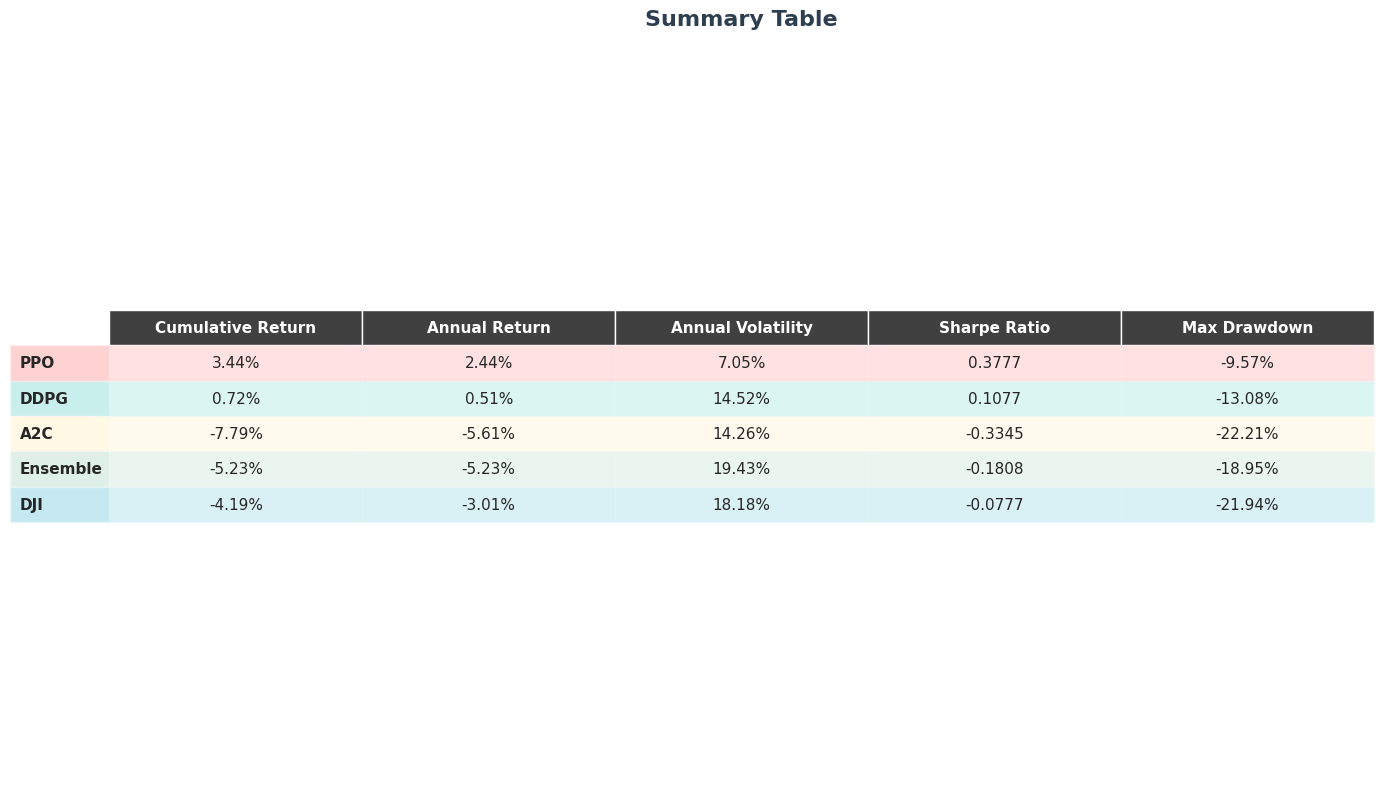

In [206]:
# Ячейка 4: Сохранение визуализаций в высоком качестве
print("Сохранение визуализаций...")

# Сохраняем все графики
import os
save_dir = "/content/drive/MyDrive/RL/visualizations"
os.makedirs(save_dir, exist_ok=True)

# Пересоздаем и сохраняем первый график (радар + heatmap)
fig1 = plt.figure(figsize=(20, 10))
# ... (повторите код из ячейки 2 для создания графиков) ...

fig1.savefig(f'{save_dir}/radar_heatmap_comparison.png', dpi=300, bbox_inches='tight')
print(f"✓ Сохранено: {save_dir}/radar_heatmap_comparison.png")

# Сохраняем второй график (барчарты)
fig2 = plt.figure(figsize=(18, 12))
# ... (повторите код из ячейки 3 для создания графиков) ...

fig2.savefig(f'{save_dir}/detailed_metrics_comparison.png', dpi=300, bbox_inches='tight')
print(f"✓ Сохранено: {save_dir}/detailed_metrics_comparison.png")

fig3, ax = plt.subplots(figsize=(14, 8))
ax.axis('tight')
ax.axis('off')

# Создаем таблицу
table_data = df.copy()

# Форматируем значения для таблицы
formatted_table = table_data.copy()
for col in formatted_table.columns:
    if col in ['Cumulative Return', 'Annual Return', 'Annual Volatility', 'Max Drawdown']:
        formatted_table[col] = formatted_table[col].apply(lambda x: f"{x*100:.2f}%" if pd.notna(x) else "N/A")
    else:
        formatted_table[col] = formatted_table[col].apply(lambda x: f"{x:.4f}" if pd.notna(x) else "N/A")

# Получаем данные для таблицы
cell_text = formatted_table.values.tolist()
row_labels = formatted_table.index.tolist()
col_labels = formatted_table.columns.tolist()

# Создаем таблицу matplotlib
table = ax.table(cellText=cell_text,
                 rowLabels=row_labels,
                 colLabels=col_labels,
                 cellLoc='center',
                 loc='center',
                 colColours=['#f0f0f0']*len(col_labels))

table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1.2, 1.8)

# Цветовое кодирование строк
model_colors = {
    'PPO': '#FF6B6B',
    'DDPG': '#4ECDC4',
    'DJI': '#45B7D1',
    'Ensemble': '#96CEB4',
    'A2C': '#FFEAA7'
}

# Используем правильные индексы для ячеек таблицы
# В matplotlib таблицах индексация начинается с (0,0) для верхней левой ячейки
# Первая строка (0) - это заголовки столбцов
for i, model in enumerate(row_labels):
    row_idx = i + 1  # +1 потому что первая строка - заголовки

    # Получаем цвет для текущей модели
    color = model_colors.get(model, '#FFFFFF')

    # Применяем цвет ко всем ячейкам в строке (включая ячейку с названием модели)
    for j in range(len(col_labels) + 1):  # +1 для столбца с названиями моделей
        try:
            cell = table[(row_idx, j)]
            cell.set_facecolor(color)
            cell.set_alpha(0.2)
            cell.set_edgecolor('white')
            cell.set_linewidth(0.5)
        except KeyError:
            # Пропускаем если ячейка не существует
            continue

# Также окрашиваем заголовки столбцов
for j in range(len(col_labels)):
    try:
        cell = table[(0, j)]
        cell.set_facecolor('#404040')
        cell.set_text_props(color='white', weight='bold')
        cell.set_edgecolor('white')
    except KeyError:
        continue

# Окрашиваем столбец с названиями моделей
for i, model in enumerate(row_labels):
    row_idx = i + 1
    try:
        cell = table[(row_idx, -1)]  # -1 для последнего столбца (названия моделей)
        cell.set_facecolor(model_colors.get(model, '#FFFFFF'))
        cell.set_alpha(0.3)
        cell.set_text_props(weight='bold')
        cell.set_edgecolor('white')
    except KeyError:
        continue

ax.set_title('Summary Table',
             fontsize=16, fontweight='bold', pad=20, color='#2c3e50')
plt.tight_layout()
fig3.savefig(f'{save_dir}/summary_table.png', dpi=300, bbox_inches='tight')
print(f"✓ Сохранено: {save_dir}/summary_table.png")

print(f"\n✅ Все визуализации сохранены в: {save_dir}")